# 2. Предобработка датасета

In [1]:
# Загрузим необходимые на данном этапе дополнительные библиотеки и инструменты

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, Normalizer,  RobustScaler
from scipy.stats import boxcox
from scipy.stats import shapiro, normaltest

In [2]:
# Загрузим наш датасет, полученный ранее посредством объединения двух других.

data = pd.read_csv('data/new_dataset.csv')


Для поиска выбросов обычно используют методы трех сигм и межквартильного интервала. Воспользуемся каждым из них для оценки количества найденных выбросов, а потом примем решение по их удалению.

Соотношение матрица-наполнитель, количество выбросов: метод трех сигм = 0, межквартильный интервал = 6


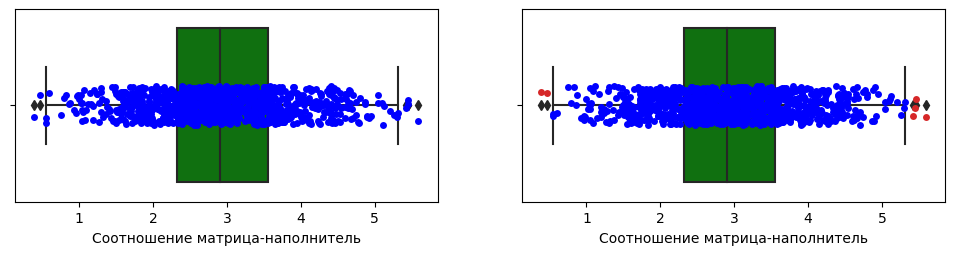

Плотность, кг/м3, количество выбросов: метод трех сигм = 3, межквартильный интервал = 9


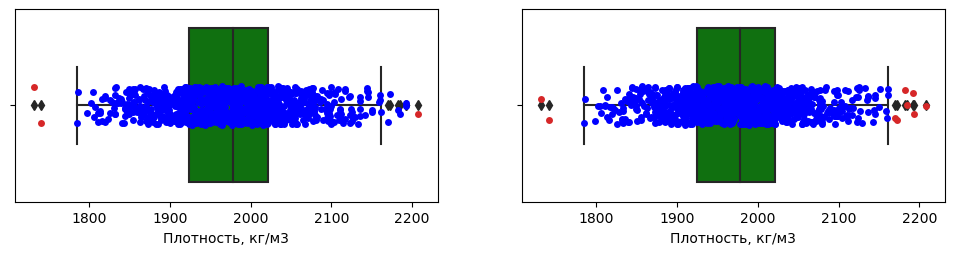

Модуль упругости, ГПа, количество выбросов: метод трех сигм = 2, межквартильный интервал = 2


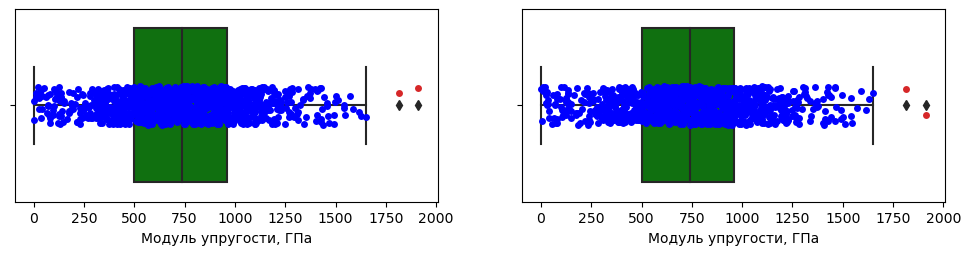

Количество отвердителя, м.%, количество выбросов: метод трех сигм = 2, межквартильный интервал = 14


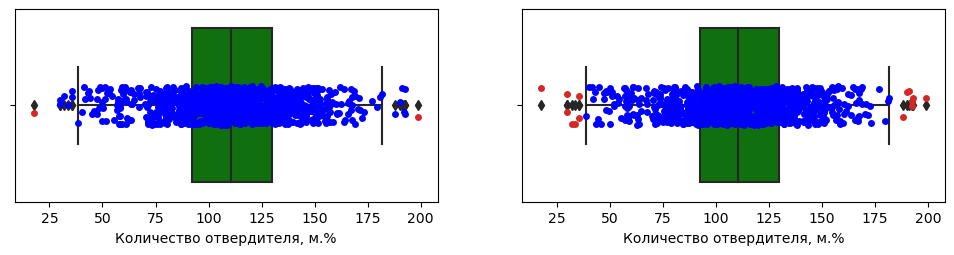

Содержание эпоксидных групп, %, количество выбросов: метод трех сигм = 2, межквартильный интервал = 2


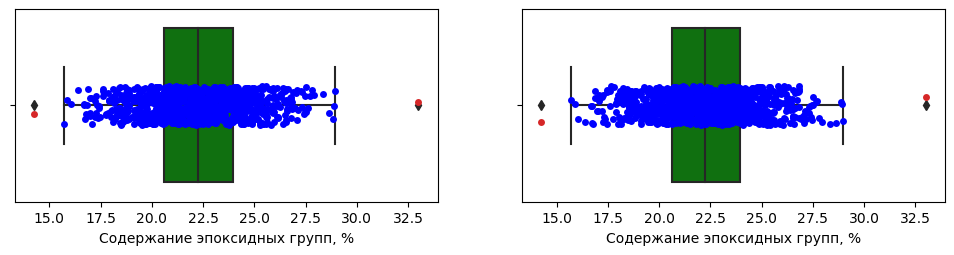

Температура вспышки, С, количество выбросов: метод трех сигм = 3, межквартильный интервал = 8


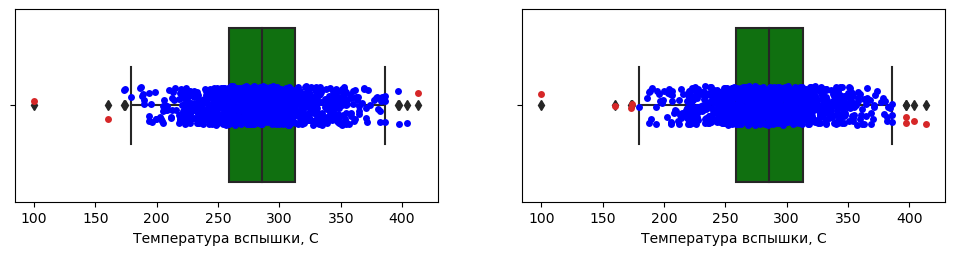

Поверхностная плотность, г/м2, количество выбросов: метод трех сигм = 2, межквартильный интервал = 2


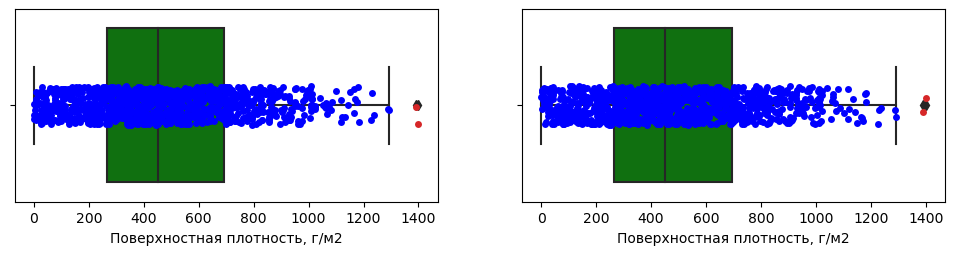

Модуль упругости при растяжении, ГПа, количество выбросов: метод трех сигм = 0, межквартильный интервал = 6


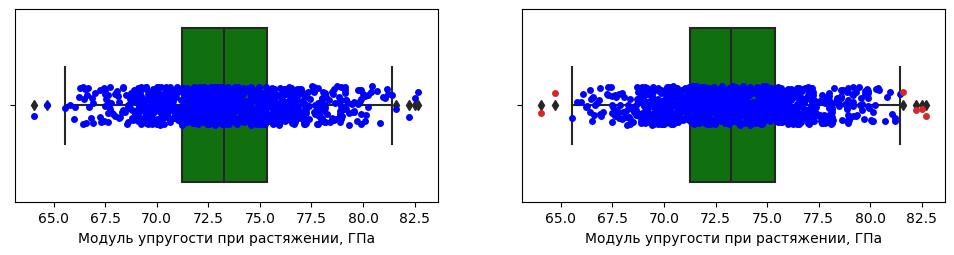

Прочность при растяжении, МПа, количество выбросов: метод трех сигм = 0, межквартильный интервал = 11


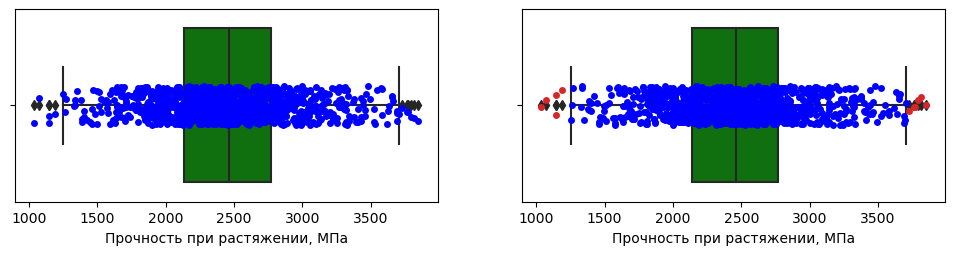

Потребление смолы, г/м2, количество выбросов: метод трех сигм = 3, межквартильный интервал = 8


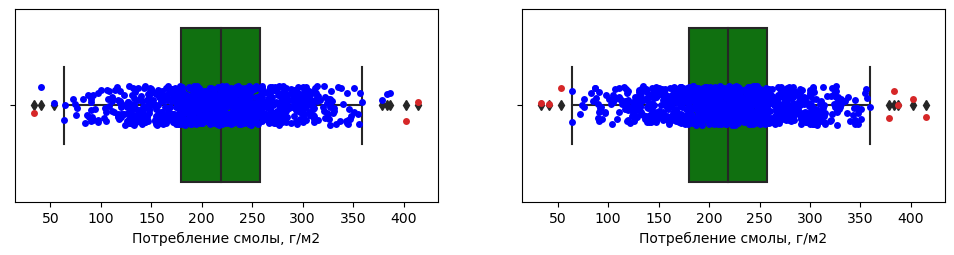

Угол нашивки, град, количество выбросов: метод трех сигм = 0, межквартильный интервал = 0


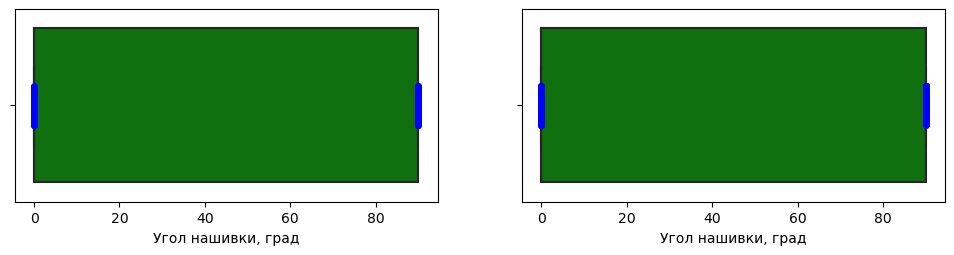

Шаг нашивки, количество выбросов: метод трех сигм = 0, межквартильный интервал = 4


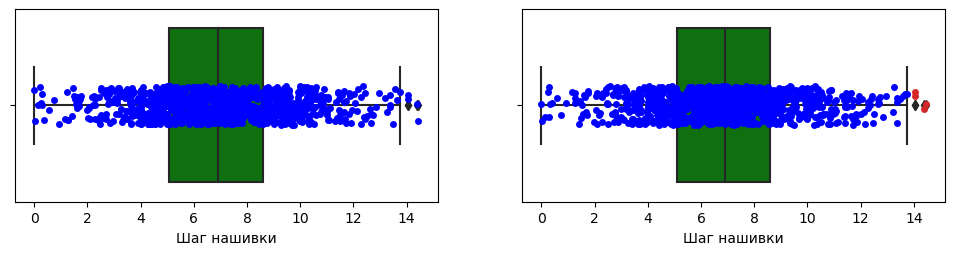

Плотность нашивки, количество выбросов: метод трех сигм = 7, межквартильный интервал = 21


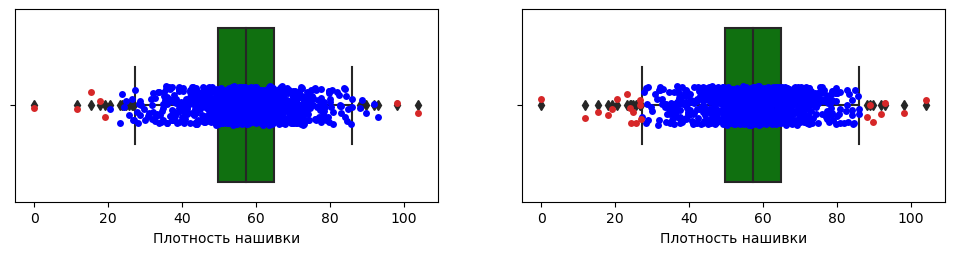

Количество выбросов, найденное по методу трех сигм: 24
Количество выбросов, найденное по методу межквартильного интервала: 93


In [3]:
# Посмотрим какое количество выбросов найдет каждый из методов и сравним значения.

amount_3s = 0
amount_iq = 0
for column in data:
    d = data.loc[:, [column]]
    
    # Применение метода трех сигм
    zscore = (data[column] - data[column].mean()) / data[column].std()
    d['3s'] = zscore.abs() > 3 
    amount_3s += d['3s'].sum() 
    
    # Применение метода межквартильного интервала
    
    q1 = np.quantile(data[column], 0.25)
    q3 = np.quantile(data[column], 0.75)
    iqr = q3 - q1
    
    # определение границ выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    d['iq'] = (data[column] < lower_bound) | (data[column] > upper_bound)
    amount_iq += d['iq'].sum()
    
    # Визуализация полученных результатов
    print('{}, количество выбросов: метод трех сигм = {}, межквартильный интервал = {}'.format(column, d['3s'].sum(), d['iq'].sum()))
    fig, axes = plt.subplots(1, 2, figsize=(12, 2.5))
    sns.boxplot(data=d, x=column, color='green', ax=axes[0])
    sns.stripplot(data=d[d['3s']==False], x=column, color='blue', ax=axes[0])  # Точечная диаграмма для значений в пределах межквартильного интервала
    sns.stripplot(data=d[d['3s']==True], x=column, color='tab:red', ax=axes[0])
    sns.boxplot(data=d, x=column, color='green', ax=axes[1])  # Ящик с усами для визуализации размаха значений
    sns.stripplot(data=d[d['iq']==False], x=column, color='blue', ax=axes[1])  # Точечная диаграмма для значений в пределах межквартильного интервала
    sns.stripplot(data=d[d['iq']==True], x=column, color='tab:red', ax=axes[1])  # Точечная диаграмма для отображения выбросов метода межквартильного интервала, выбросы отмечены красным цветом
    plt.show()

# Вывод общего количества выбросов для каждого метода
print('Количество выбросов, найденное по методу трех сигм:', amount_3s)
print('Количество выбросов, найденное по методу межквартильного интервала:', amount_iq)

В итоге у нас получились следующие результаты.

Количество выбросов, найденное по методу трех сигм: 24; количество выбросов, найденное по методу межквартильного интервала: 93.

В целях полного удаления выбросов воспользуемся методом межквартильного интервала. Этот метод предпочтителен еще и по той причине, что он неплохо подходит и для ненормально распределенных значений. Ну и конкретно применительно к нашему датасету я решил воспользоваться этим методом, поскольку, как нам было сказано, датасет во многом синтетический, много искусственных данных, которые в силу неверных параметров,  вероятно, как раз сильно и искажают обущю картину с зависимостями между параметрами. С другим реальным датасетом с учетом небольшого количества данных, скорее всего, остановился бы на методе трех сигм.

In [4]:
# Еще раз используем метод межквартильных интервалов для поиска выбросов и заменим их на NaN (отсутствие значений)

for column in data:
    q1 = np.quantile(data[column], 0.25)
    q3 = np.quantile(data[column], 0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = np.nan # Замена значения, находящиеся за пределами межквартильного интервала, на NaN

In [5]:
# Проверим получившееся количество количество выбросов, переделанных в NaN

data.isnull().sum()

Соотношение матрица-наполнитель          6
Плотность, кг/м3                         9
Модуль упругости, ГПа                    2
Количество отвердителя, м.%             14
Содержание эпоксидных групп, %           2
Температура вспышки, С                   8
Поверхностная плотность, г/м2            2
Модуль упругости при растяжении, ГПа     6
Прочность при растяжении, МПа           11
Потребление смолы, г/м2                  8
Угол нашивки, град                       0
Шаг нашивки                              4
Плотность нашивки                       21
dtype: int64

In [6]:
# Удаление строк, содержащих NaN
data = data.dropna(axis=0)

# Перезапустим заново индексацию очищенного датасета
data.reset_index(drop=True, inplace=True)

In [7]:
# Очищенный датасет тоже сохраним

data.to_csv('data/cleaned_dataset.csv', index=False)

Теперь изучим датасет на предмет выяснения необходимости проведения нормализации и понимания какими методами это лучше осуществить.

In [8]:
# Сначала проведем статистические тесты на нормальность распределения данных для каждого столбца в датасете с использованием тестов Пирсона и Шапиро-Уилка

result_data = pd.DataFrame(columns=['pearson p-value', 'shapiro p-value'])

# Итерируем по столбцам в DataFrame
for column in data.columns:
    # Тест по Пирсону
    _, pearson_p_value = normaltest(data[column])
    
    # Тест по Шапиро-Уилку
    _, shapiro_p_value = shapiro(data[column])
    
    # Записываем p-value в таблицу
    result_data.loc[column] = [round(pearson_p_value, 6), round(shapiro_p_value, 6)]

# Выводим результат
print(result_data)

                                      pearson p-value  shapiro p-value
Соотношение матрица-наполнитель              0.064087         0.086759
Плотность, кг/м3                             0.350121         0.094850
Модуль упругости, ГПа                        0.019018         0.006075
Количество отвердителя, м.%                  0.072428         0.025072
Содержание эпоксидных групп, %               0.064916         0.237023
Температура вспышки, С                       0.084906         0.085307
Поверхностная плотность, г/м2                0.000000         0.000000
Модуль упругости при растяжении, ГПа         0.040235         0.023090
Прочность при растяжении, МПа                0.237467         0.078110
Потребление смолы, г/м2                      0.012970         0.015642
Угол нашивки, град                           0.000000         0.000000
Шаг нашивки                                  0.638223         0.349185
Плотность нашивки                            0.376078         0.052167


Как видим, в двух столбцах "Поверхностная плотность" и "Угол нашивки" распределение данных вообще не соответствует нормальному распределению.

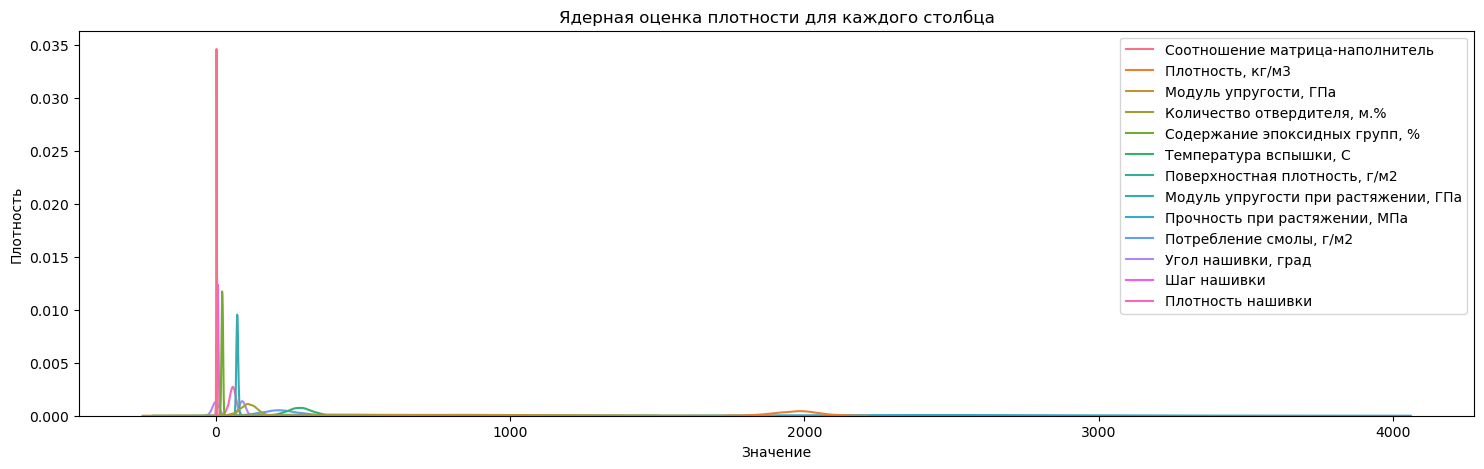

In [9]:
# Теперь построим график ядерной оценки плотности наших признаков до нормализации

fig, ax = plt.subplots(figsize=(18, 5))
sns.kdeplot(data=data, ax=ax)
plt.title('Ядерная оценка плотности для каждого столбца')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.show()

По графику видно, что данные находятся в разных диапазонах. В данной связи необходима нормализация данных. В нашем случае, прежде всего, целесообразно воспользоваться методом MinMaxScaler, чтобы привести значения в диапазон от 0 до 1.

Но здесь нужно иметь ввиду следующее. Если мы применим данный метод, как и другие методы нормализации, ко всему датасету, то информацию о нем (в частности, среднее значение и дисперсию) впоследствии мы передадим и в обучающие объясняющие переменные.

Следовательно, нам нужно выполнить нормализацию сначала для обучающих данных, а затем уже выполним нормализацию и для тестовых экземпляров, но на этот раз используя среднее значение и дисперсию обучающих объясняющих переменных. Таким образом, мы можем протестировать и оценить, может ли наша модель хорошо обобщаться на новые, невидимые точки данных.

Как говорилось выше, перед проведением нормализации произведем сначала разбивку наших данных на обучающую и тестовые выборки.

In [10]:
# Загрузим наш очищенный датасет

df = pd.read_csv('data/cleaned_dataset.csv')

# Уберем целевые параметры из датасета и выенесем их в отдельные целевые переменные

X_1 = df.drop(columns= ['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'])
y_upr = df[['Модуль упругости при растяжении, ГПа']]
y_pr = df[['Прочность при растяжении, МПа']]

# Произведем разбивку на обучающую и тестовую выборки для прогноза искомых целевых параметров: модуля упругости при растяжении и прочности при растяжении

X_train, X_test, y_train_upr, y_test_upr = train_test_split(X_1, y_upr, test_size=0.3, random_state=1)
X_train, X_test, y_train_pr, y_test_pr = train_test_split(X_1, y_pr, test_size=0.3, random_state=1)
print(X_train.shape, y_train_upr.shape, y_train_pr.shape)
print(X_test.shape, y_test_upr.shape, y_test_pr.shape)

(655, 11) (655, 1) (655, 1)
(281, 11) (281, 1) (281, 1)


In [11]:
# Проведем то же самое с датасетом для решения задачи по предсказанию соотношения матрица-наполнитель

df_1 = pd.read_csv('data/cleaned_dataset.csv')
X_2 = df_1.drop(columns= ['Соотношение матрица-наполнитель'])
y_mn = df_1[['Соотношение матрица-наполнитель']]

In [12]:
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(X_2, y_mn, test_size=0.3, random_state=1)
print(X_train_mn.shape, y_train_mn.shape)
print(X_test_mn.shape, y_test_mn.shape)

(655, 12) (655, 1)
(281, 12) (281, 1)


Теперь приступаем к нормализации данных при помощи метода MinMaxScaler.

Сначала создадим объект MinMaxScaler для нормализации/масштабированию данных для тренировочных датасетов для первых двух задач по прогнозированию параметров 'Модуль упругости при растяжении, ГПа' и 'Прочность при растяжении, МПа. 

In [13]:
# Создание объекта MinMaxScaler 

scaler_upr_X = MinMaxScaler()

# Обучение объекта MinMaxScaler и масштабирование обучающих данных для значений X модуля упругости при растяжении

X_train_scl = scaler_upr_X.fit_transform(X_train)

# То же самое для значений у

scaler_upr_y = MinMaxScaler()
y_train_scl_upr= scaler_upr_y.fit_transform(y_train_upr)

Проделаем то же самое для прочности при растяжении

In [14]:
# Создание объекта MinMaxScaler 

scaler_pr_X = MinMaxScaler()

# Обучение объекта MinMaxScaler и масштабирование обучающих данных для значений X прочности при растяжении

X_train_scl = scaler_pr_X.fit_transform(X_train)

# То же самое для значений у

scaler_pr_y = MinMaxScaler()
y_train_scl_pr= scaler_pr_y.fit_transform(y_train_pr)

Теперь применим обученные на тренировочных данных "скейлер" к тестовым выборкам.

In [15]:
# Сначала для значений Х и у модуля упругости при растяжении и прочности при растяжении

X_test_scl = scaler_upr_X.transform(X_test)
y_test_scl_upr = scaler_upr_y.transform(y_test_upr)

In [16]:
# Теперь то же самое для значений Х и у прочности при растяжении

X_test_scl = scaler_pr_X.transform(X_test)
y_test_scl_pr = scaler_pr_y.transform(y_test_pr)

Теперь проделаем то же самое для тренировочной выборки для третьей задачи по предсказанию соотношения матрица-наполнитель.

In [17]:
scaler_mn_X = MinMaxScaler()
X_train_scl_mn = scaler_mn_X.fit_transform(X_train_mn)

scaler_mn_y = MinMaxScaler()
y_train_scl_mn = scaler_mn_y.fit_transform(y_train_mn)

# Применим обученный на тренировочных данных "скейлер" к тестовым выборкам

X_test_scl_mn = scaler_mn_X.transform(X_test_mn)
y_test_scl_mn = scaler_mn_y.transform(y_test_mn)

Сохраним получившиеся скейлеры, они нам впоследствии пригодятся при создании Flask-приложения.

In [18]:
# Масштабаторы для X
pickle.dump(scaler_upr_X, open('flask/models/scaler_X_upr.pickle', 'wb'))
pickle.dump(scaler_pr_X, open('flask/models/scaler_X_pr.pickle', 'wb'))
pickle.dump(scaler_mn_X, open('flask/models/scaler_X_mn.pickle', 'wb'))

# Масштабаторы для y
pickle.dump(scaler_upr_y, open('flask/models/scaler_y_upr.pickle', 'wb'))
pickle.dump(scaler_pr_y, open('flask/models/scaler_y_pr.pickle', 'wb'))
pickle.dump(scaler_mn_y, open('flask/models/scaler_y_mn.pickle', 'wb'))

# 3. Обучение моделей

In [180]:
# Загрузим необходимые на данном этапе библиотеки

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Для удобства и оптимальной работы с кодом напишем несколько шаблонов/функций, которые будем в дальнейшем использовать при различных моделях машинного обучения. 

# Модель для модуля упругости при растяжении

In [20]:
# Функция по поиску лучших параметров

def find_params_upr(model, param_grid, X, y, cv=15):
    
    # Поиск по сетке
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring = 'neg_mean_absolute_error', verbose=True, n_jobs=-1)
    grid_search.fit(X_train_scl, y_train_scl_upr)
    
    # Лучшие параметры
    print()
    print(pd.DataFrame(grid_search.best_params_, index=[f'Параметры лучшей модели {type(model).__name__}']).T)
    
    return grid_search.best_params_


In [21]:
# Функция, рассчитывающая метрики MSE, R2 и MAE

def evaluate_upr(model, best_param):
    
    # метрики для оценок
    scoring = ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"]
    
    # расчет на кросс-валидации
    scores_train = cross_validate(model.set_params(**best_param), X_train_scl, y_train_scl_upr, scoring=scoring, n_jobs=-1)
    
    # обучение модели на тренировочных данных
    model_test = model.set_params(**best_param)
    model_test.fit(X_train_scl, y_train_scl_upr)
    
    # предсказание на тестовой выборке
    y_pred_test = model_test.predict(X_test_scl)

    # расчет метрик на тестовой выборке
    mse_test = mean_squared_error(y_test_scl_upr, y_pred_test)
    mae_test = mean_absolute_error(y_test_scl_upr, y_pred_test)
    r2_test = r2_score(y_test_scl_upr, y_pred_test)

    # Создание DataFrame с результатами для одной модели
    model_name = type(model).__name__
    model_results_df = pd.DataFrame({
        model_name: {
            'MSE_train': -scores_train["test_neg_mean_squared_error"].mean().round(4),
            'MSE_test': mse_test.round(4),
            'MAE_train': -scores_train["test_neg_mean_absolute_error"].mean().round(4),
            'MAE_test': mae_test.round(4),
            'R2_train': scores_train["test_r2"].mean().round(4),
            'R2_test': r2_test.round(4),
        }
    }, index=['MSE_train', 'MSE_test', 'MAE_train', 'MAE_test', 'R2_train', 'R2_test'])

    # Обновление глобального DataFrame
    global total_results_upr
    if total_results_upr.empty:
        total_results_upr = model_results_df
    else:
        total_results_upr = pd.concat([total_results_upr, model_results_df], axis=1)

    return model_results_df

In [22]:
#Визуализация предсказанных значений целевых переменных

def pred_test_visual_upr(y_test_scl_upr, y_pred, model_name):
    y_test_scl_upr_series = pd.Series(y_test_scl_upr.ravel())
    plt.figure(figsize=(9, 5))
    plt.title(f'Тестовые и прогнозные значения для модели {model_name}')
    plt.plot(y_test_scl_upr_series, label='Тест', color='green')
    plt.plot(y_pred.ravel(), label='Прогноз', color='red')
    plt.xlabel('Порядковый номер попытки сравнения')
    plt.ylabel('Значения')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [23]:
# Глобальный DataFrame для хранения результатов для всех моделей upr

total_results_upr = pd.DataFrame()

Теперь приступим к поиску лучших параметров, обучению моделей и визуализации результатов их обучения.

### Линейная регрессия (LinearRegression)

In [24]:
# Найдем лучшие параметры

lr_upr = LinearRegression()
lr_params = {
    'fit_intercept' : [True, False]
}
best_params_lr_upr = find_params_upr(lr_upr, lr_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 2 candidates, totalling 30 fits

               Параметры лучшей модели LinearRegression
fit_intercept                                      True


In [25]:
# Рассчитаем метрики MSE, MAE и R2 для KNeighborsRegressor

evaluate_upr(lr_upr, best_params_lr_upr)

LinearRegression
MSE_train            0.0369
MSE_test             0.0379
MAE_train            0.1532
MAE_test             0.1605
R2_train            -0.0185
R2_test             -0.0193

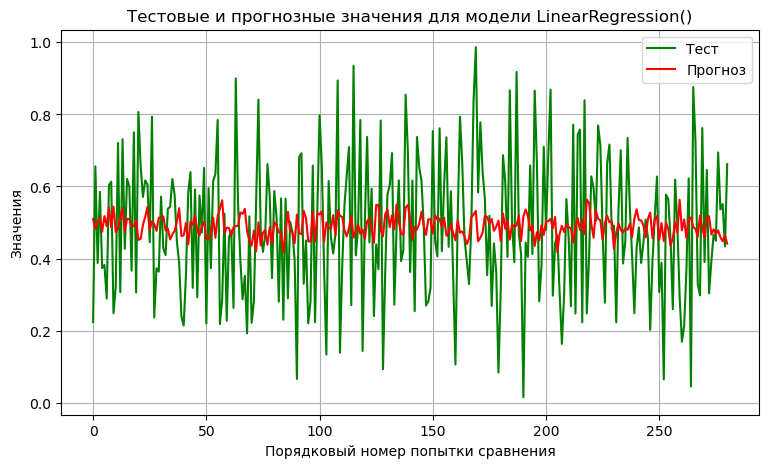

In [26]:
# Выполним прогнозирование и сранвим его результаты с фактическими тестовыми значениями.

y_pred = lr_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, lr_upr)

### KNeighborsRegressor

In [27]:
# Найдем лучшие параметры

knr_upr = KNeighborsRegressor()

# Задание сетки гиперпараметров
knr_params = {
    'n_neighbors': range(1, 301, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

best_params_knr_upr = find_params_upr(knr_upr, knr_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 1200 candidates, totalling 18000 fits

            Параметры лучшей модели KNeighborsRegressor
algorithm                                          auto
n_neighbors                                          45
weights                                         uniform


In [28]:
# Функция, рассчитывающая метрики MSE, MAE и R2  

evaluate_upr(knr_upr, best_params_knr_upr)

KNeighborsRegressor
MSE_train               0.0364
MSE_test                0.0380
MAE_train               0.1518
MAE_test                0.1620
R2_train               -0.0060
R2_test                -0.0233

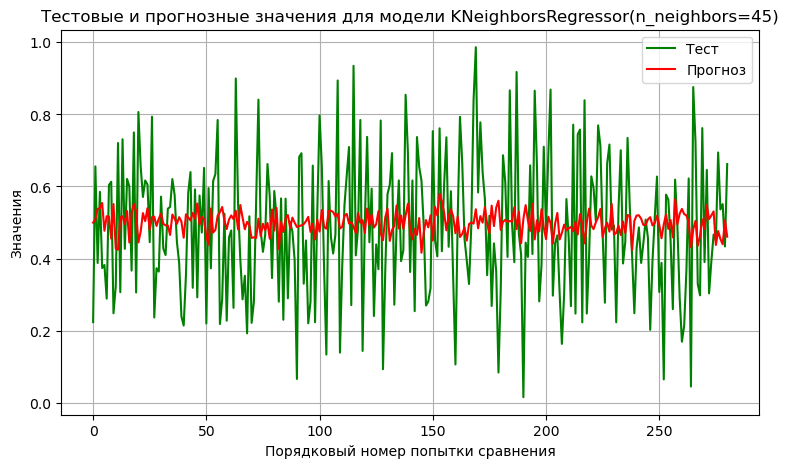

In [29]:
# Выполним  прогнозирование и сранвим его результаты с фактическими тестовыми данными

y_pred = knr_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, knr_upr)

### Ridge

In [169]:
# Найдем лучшие параметры
ridge_upr = Ridge()

# Задание сетки гиперпараметров
ridge_params = {
    'alpha': [0.1, 1.0, 10.0],  # Различные значения коэффициента регуляризации
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Различные методы оптимизации
}

best_params_ridge_upr = find_params_upr(ridge_upr, ridge_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 21 candidates, totalling 315 fits

       Параметры лучшей модели Ridge
alpha                           10.0
solver                     sparse_cg


In [170]:
# Функция, рассчитывающая метрики MSE, MAE и R2 

evaluate_upr(ridge_upr, best_params_ridge_upr)

Ridge
MSE_train  0.0366
MSE_test   0.0375
MAE_train  0.1526
MAE_test   0.1598
R2_train  -0.0092
R2_test   -0.0088

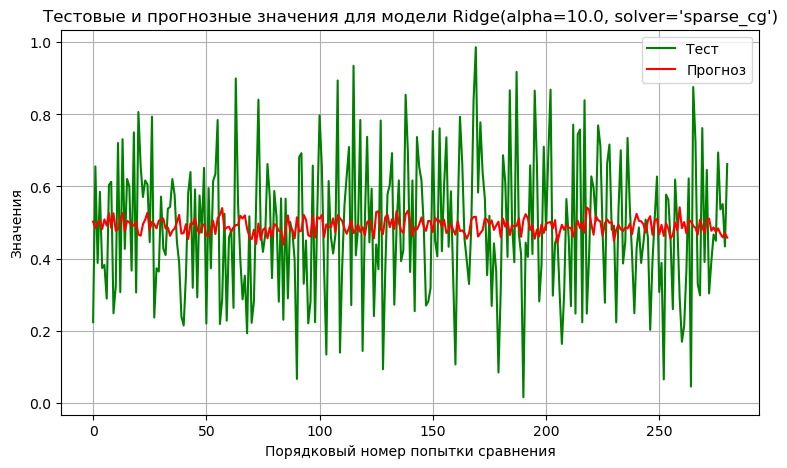

In [171]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = ridge_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, ridge_upr)

### Стохастический градиентный спуск (Stochastic Gradient Descent, SGD) 

In [30]:
# Подберем лучшие параметры

sgd_upr = SGDRegressor()
sgd_params = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.5],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
    'epsilon': [0.1, 0.01, 0.001],
    'random_state': [42]  # Для воспроизводимости результатов
}
best_params_sgd_upr = find_params_upr(sgd_upr, sgd_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 15552 candidates, totalling 233280 fits

              Параметры лучшей модели SGDRegressor
alpha                                        0.001
epsilon                                        0.1
eta0                                           0.1
learning_rate                           invscaling
loss                           epsilon_insensitive
max_iter                                      1000
penalty                                         l1
random_state                                    42
tol                                          0.001


In [31]:
# Функция, рассчитывающая метрики MSE, MAE и R2 

evaluate_upr(sgd_upr, best_params_sgd_upr)

SGDRegressor
MSE_train        0.0421
MSE_test         0.0386
MAE_train        0.1632
MAE_test         0.1625
R2_train        -0.1696
R2_test         -0.0378

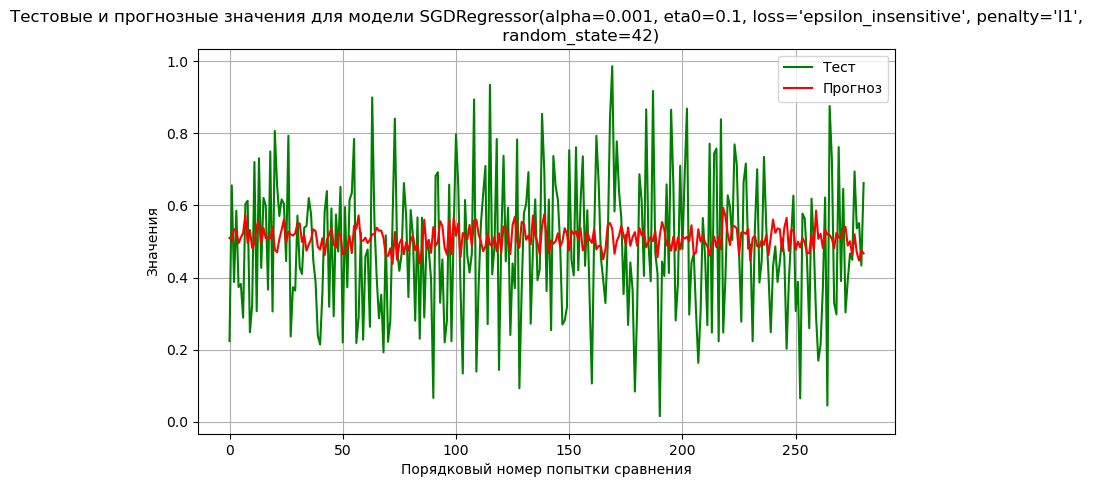

In [32]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = sgd_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, sgd_upr)

### Градиентный бустинг (GradientBoostingRegressor)

In [33]:
# Подберем лучшие параметры

gb_upr = GradientBoostingRegressor()
gb_params = {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 
                  'n_estimators': [1, 2, 5, 10],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 5, 10]}
best_params_gb_upr = find_params_upr(gb_upr, gb_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 320 candidates, totalling 4800 fits

             Параметры лучшей модели GradientBoostingRegressor
loss                                            absolute_error
max_depth                                                    5
max_features                                                 1
n_estimators                                                 5


In [34]:
# Функция, рассчитывающая метрики MSE, MAE и R2  

evaluate_upr(gb_upr, best_params_gb_upr)

GradientBoostingRegressor
MSE_train                     0.0364
MSE_test                      0.0376
MAE_train                     0.1524
MAE_test                      0.1600
R2_train                     -0.0025
R2_test                      -0.0123

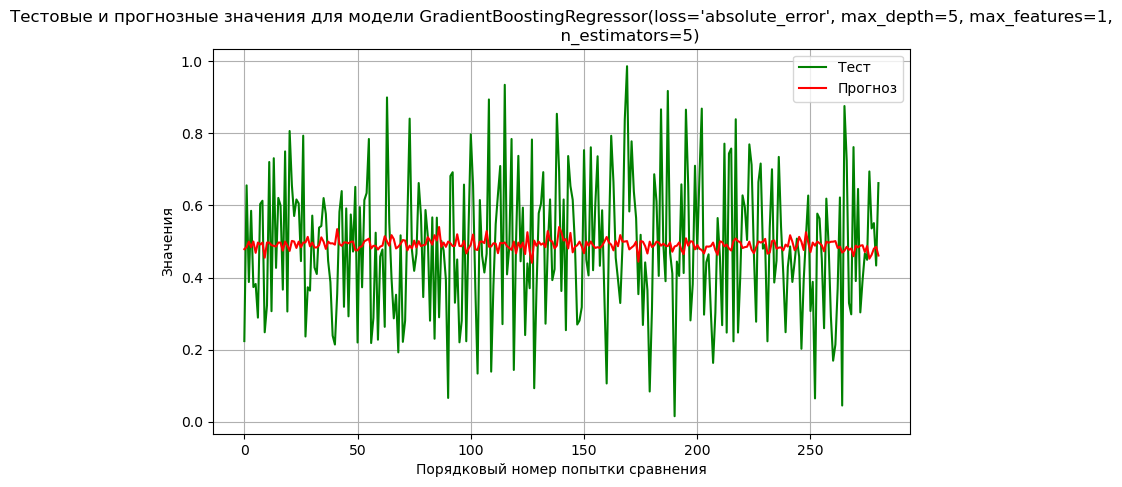

In [35]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = gb_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, gb_upr)

### Метод опорных векторов (Support Vector Regression, SVR)

In [36]:
# Подберем лучшие параметры

svr_upr = SVR()
svr_params =  {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'C': [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1, 0.5]}
best_params_svr_upr = find_params_upr(svr_upr, svr_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 40 candidates, totalling 600 fits

       Параметры лучшей модели SVR
C                            0.005
kernel                         rbf


In [37]:
# Функция, рассчитывающая метрики MSE, MAE и R2  

evaluate_upr(svr_upr, best_params_svr_upr)

SVR
MSE_train  0.0365
MSE_test   0.0371
MAE_train  0.1525
MAE_test   0.1589
R2_train  -0.0059
R2_test    0.0025

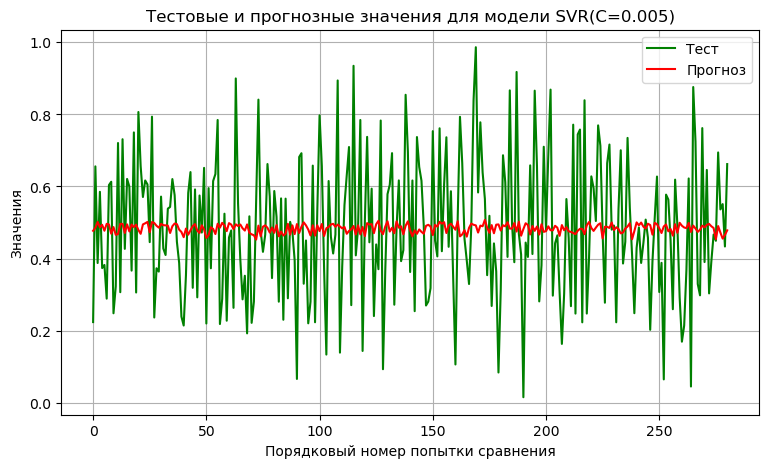

In [38]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = svr_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, svr_upr)

### "Случайный лес" (RandomForestRegressor)

In [39]:
# Подберем лучшие параметры

forest_upr = RandomForestRegressor(random_state=0)
forest_params = {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 5, 7],
                'min_samples_split': [2, 4, 8],
                'min_samples_leaf': [1, 2, 4],
               }
best_params_forest_upr = find_params_upr(forest_upr, forest_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits

                   Параметры лучшей модели RandomForestRegressor
max_depth                                                      3
min_samples_leaf                                               2
min_samples_split                                              2
n_estimators                                                 200


In [40]:
# Функция, рассчитывающая метрики MSE, MAE и R2 

evaluate_upr(forest_upr, best_params_forest_upr)

RandomForestRegressor
MSE_train                 0.0362
MSE_test                  0.0380
MAE_train                 0.1516
MAE_test                  0.1606
R2_train                  0.0013
R2_test                  -0.0221

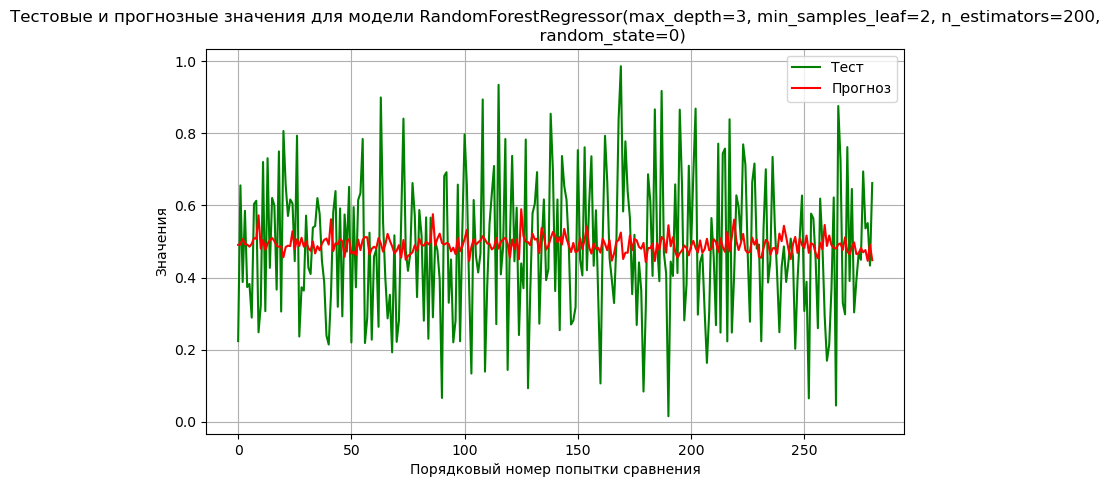

In [41]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = forest_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, forest_upr)

### XGBRegressor

In [42]:
# Подберем лучшие параметры

xgb_upr = XGBRegressor(random_state=0)

xgb_params = {
              'booster': ['gbtree', 'dart'],            # dart - c прорежеванием
              'n_estimators': [10, 50, 100],       # число деревьев
              'max_depth': [3, 5, 7],               # максимальная глубина дерева
              'learning_rate': [0.01, 0.02, 0.1],
              'subsample': [0.5, 0.7],             # доля обучающих образцов
              'colsample_bytree': [0.5, 0.7, 1.0],      # доля обучающих признаков
              'n_jobs': [-1]
             }
best_params_xgb_upr = find_params_upr(xgb_upr, xgb_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 324 candidates, totalling 4860 fits

                 Параметры лучшей модели XGBRegressor
booster                                          dart
colsample_bytree                                  0.7
learning_rate                                     0.1
max_depth                                           7
n_estimators                                       10
n_jobs                                             -1
subsample                                         0.5


In [43]:
# Функция, рассчитывающая метрики MSE, MAE и R2 

evaluate_upr(xgb_upr, best_params_xgb_upr)

XGBRegressor
MSE_train        0.0379
MSE_test         0.0400
MAE_train        0.1543
MAE_test         0.1641
R2_train        -0.0435
R2_test         -0.0773

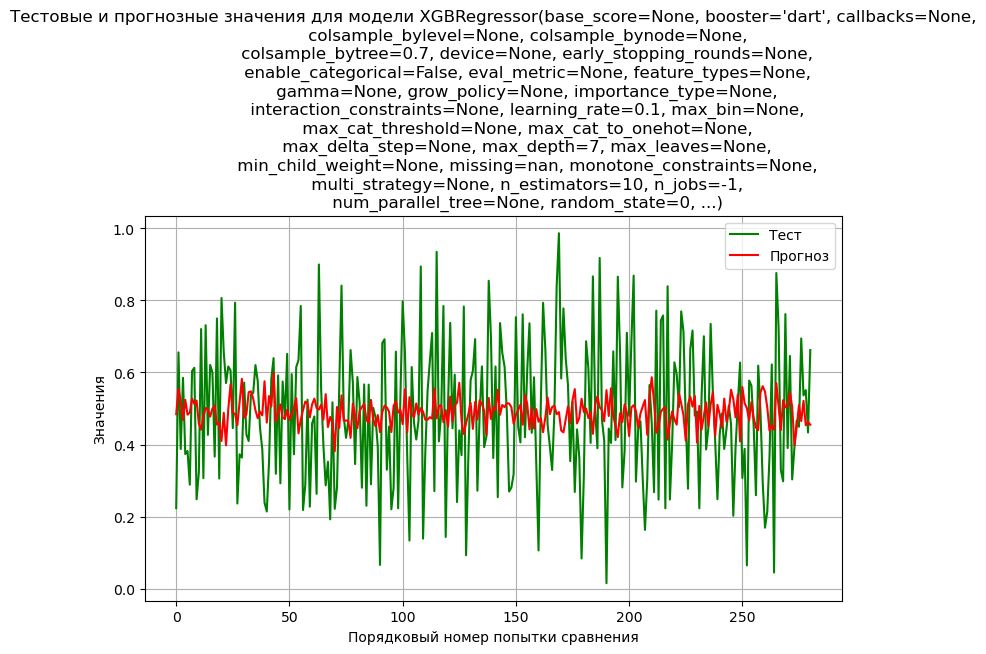

In [44]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = xgb_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, xgb_upr)

### Деревья решений (DecisionTreeRegressor)

In [182]:
# Подберем лучшие параметры

dtr_upr = DecisionTreeRegressor()

dtr_params = {
    'max_depth': [5, 10, 20, 30],  # Глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество выборок для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество выборок в листовом узле
    'max_features': ['auto', 'sqrt', 'log2'],  # Максимальное количество признаков для разделения
}

best_params_dtr_upr = find_params_upr(dtr_upr, dtr_params, X_train_scl, y_train_scl_upr)

Fitting 15 folds for each of 135 candidates, totalling 2025 fits

                  Параметры лучшей модели DecisionTreeRegressor
max_depth                                                     5
max_features                                               log2
min_samples_leaf                                              1
min_samples_split                                             2


In [183]:
evaluate_upr(dtr_upr, best_params_dtr_upr)

DecisionTreeRegressor
MSE_train                 0.0410
MSE_test                  0.0406
MAE_train                 0.1598
MAE_test                  0.1659
R2_train                 -0.1330
R2_test                  -0.0918

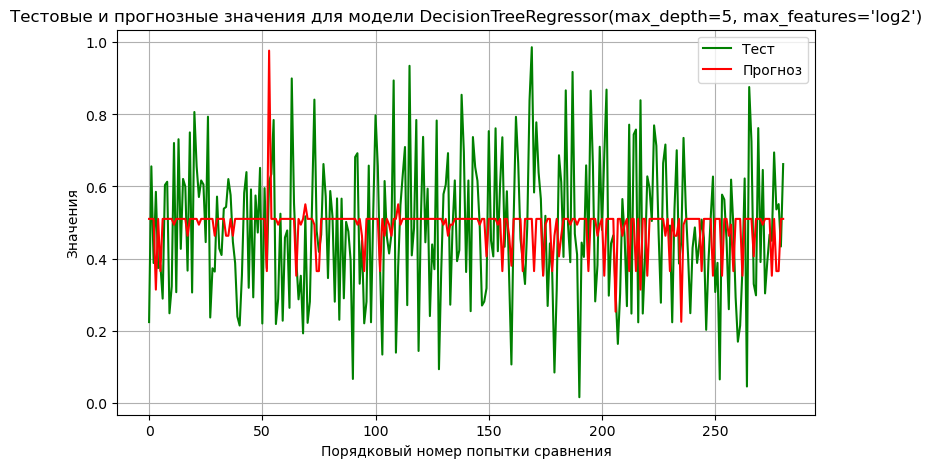

In [184]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = dtr_upr.predict(X_test_scl)
pred_test_visual_upr(y_test_scl_upr, y_pred, dtr_upr)

Выведем итоговые результаты обучения моделей.

In [189]:
total_results_upr.T

MSE_train  MSE_test  MAE_train  MAE_test  R2_train  \
LinearRegression              0.0369    0.0379     0.1532    0.1605   -0.0185   
KNeighborsRegressor           0.0364    0.0380     0.1518    0.1620   -0.0060   
SGDRegressor                  0.0421    0.0386     0.1632    0.1625   -0.1696   
GradientBoostingRegressor     0.0364    0.0376     0.1524    0.1600   -0.0025   
SVR                           0.0365    0.0371     0.1525    0.1589   -0.0059   
RandomForestRegressor         0.0362    0.0380     0.1516    0.1606    0.0013   
XGBRegressor                  0.0379    0.0400     0.1543    0.1641   -0.0435   
Ridge                         0.0366    0.0375     0.1526    0.1598   -0.0092   
DecisionTreeRegressor         0.0410    0.0406     0.1598    0.1659   -0.1330   

                           R2_test  
LinearRegression           -0.0193  
KNeighborsRegressor        -0.0233  
SGDRegressor               -0.0378  
GradientBoostingRegressor  -0.0123  
SVR                         0.0025  
RandomForestRegressor      -0.0221  
XGBRegressor               -0.0773  
Ridge                      -0.0088  
DecisionTreeRegressor      -0.0918

Лучшие результаты показал метод опорных векторов (SVR), прогнозные значения которого, как это видно из графика, были близки к простому усреднению.

Теперь проведем те же самые действия по обучению моделей для прогнозирования значений параметра "Прочность при растяжении"

# Модель для прочности при растяжении

In [46]:
# Функция по поиску лучших параметров

def find_params_pr(model, param_grid, X, y, cv=15):
    
    # Поиск по сетке
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring = 'neg_mean_absolute_error', verbose=True, n_jobs=-1)
    grid_search.fit(X_train_scl, y_train_scl_pr)
    
    # Лучшие параметры
    print()
    print(pd.DataFrame(grid_search.best_params_, index=[f'Параметры лучшей модели {type(model).__name__}']).T)
    
    return grid_search.best_params_

In [47]:
# Функция, рассчитывающая метрики MSE, R2 и MAE

def evaluate_pr(model, best_param):
    '''
    Функция, рассчитывающая метрики MSE, R2 и MAE
    '''
    
    # метрики для оценок
    scoring = ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"]
    
    # расчет на кросс-валидации
    scores_train = cross_validate(model.set_params(**best_param), X_train_scl, y_train_scl_pr, scoring=scoring, n_jobs=-1)
    
    # обучение модели на тренировочных данных
    model_test = model.set_params(**best_param)
    model_test.fit(X_train_scl, y_train_scl_pr)
    
    # предсказание на тестовой выборке
    y_pred_test = model_test.predict(X_test_scl)

    # расчет метрик на тестовой выборке
    mse_test = mean_squared_error(y_test_scl_pr, y_pred_test)
    mae_test = mean_absolute_error(y_test_scl_pr, y_pred_test)
    r2_test = r2_score(y_test_scl_pr, y_pred_test)

    # Создание DataFrame с результатами для одной модели
    model_name = type(model).__name__
    model_results_df = pd.DataFrame({
        model_name: {
            'MSE_train': -scores_train["test_neg_mean_squared_error"].mean().round(4),
            'MSE_test': mse_test.round(4),
            'MAE_train': -scores_train["test_neg_mean_absolute_error"].mean().round(4),
            'MAE_test': mae_test.round(4),
            'R2_train': scores_train["test_r2"].mean().round(4),
            'R2_test': r2_test.round(4),
        }
    }, index=['MSE_train', 'MSE_test', 'MAE_train', 'MAE_test', 'R2_train', 'R2_test'])

    # Обновление глобального DataFrame
    global total_results_pr
    if total_results_pr.empty:
        total_results_pr = model_results_df
    else:
        total_results_pr = pd.concat([total_results_pr, model_results_df], axis=1)

    return model_results_df

In [48]:
#Визуализация предсказанных значений целевых переменных

def pred_test_visual_pr(y_test_scl_pr, y_pred, model_name):
    y_test_scl_pr_series = pd.Series(y_test_scl_pr.ravel())
    plt.figure(figsize=(9, 5))
    plt.title(f'Тестовые и прогнозные значения для модели {model_name}')
    plt.plot(y_test_scl_pr_series, label='Тест', color='black')
    plt.plot(y_pred.ravel(), label='Прогноз', color='red')
    plt.xlabel('Порядковый номер попытки сравнения')
    plt.ylabel('Значения')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [49]:
# Глобальный DataFrame для хранения результатов для всех моделей pr

total_results_pr = pd.DataFrame()

Теперь приступим к поиску лучших параметров, обучению моделей и визуализации результатов их обучения.

### Линейная регрессия (LinearRegression)

In [50]:
# Найдем лучшие параметры

lr_pr = LinearRegression()
lr_params = {
    'fit_intercept' : [True, False]
}
best_params_lr_pr = find_params_pr(lr_pr, lr_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 2 candidates, totalling 30 fits

               Параметры лучшей модели LinearRegression
fit_intercept                                      True


In [51]:
# Рассчитаем метрики MSE, MAE и R2 для KNeighborsRegressor

evaluate_pr(lr_pr, best_params_lr_pr)

LinearRegression
MSE_train            0.0380
MSE_test             0.0354
MAE_train            0.1550
MAE_test             0.1515
R2_train            -0.0520
R2_test             -0.0183

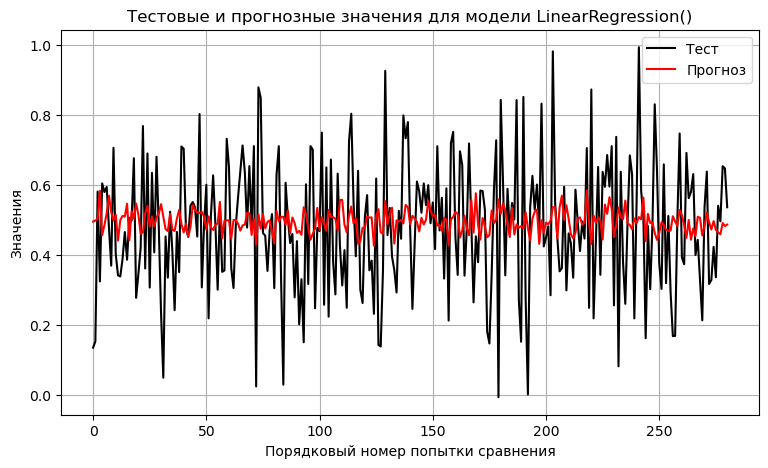

In [52]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными

y_pred = lr_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, lr_pr)

###  KNeighborsRegressor

In [53]:
# Найдем лучшие параметры

knr_pr = KNeighborsRegressor()

# Задание сетки гиперпараметров
knr_params = {
    'n_neighbors': range(1, 301, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

best_params_knr_pr = find_params_pr(knr_pr, knr_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 1200 candidates, totalling 18000 fits

            Параметры лучшей модели KNeighborsRegressor
algorithm                                          auto
n_neighbors                                         149
weights                                         uniform


In [54]:
# Рассчитаем метрики MSE, MAE и R2 для KNeighborsRegressor

evaluate_pr(knr_pr, best_params_knr_pr)

KNeighborsRegressor
MSE_train               0.0369
MSE_test                0.0353
MAE_train               0.1528
MAE_test                0.1513
R2_train               -0.0219
R2_test                -0.0172

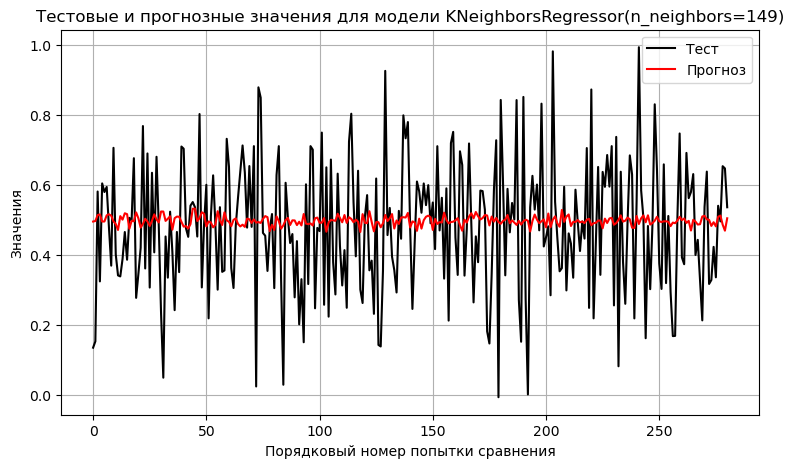

In [55]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными

y_pred = knr_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, knr_pr)

### Ridge

In [173]:
# Найдем лучшие параметры
ridge_pr = Ridge()

# Задание сетки гиперпараметров
ridge_params = {
    'alpha': [0.1, 1.0, 10.0],  # Различные значения коэффициента регуляризации
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Различные методы оптимизации
}

best_params_ridge_pr = find_params_pr(ridge_pr, ridge_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 21 candidates, totalling 315 fits

       Параметры лучшей модели Ridge
alpha                           10.0
solver                          auto


In [174]:
# Функция, рассчитывающая метрики MSE, MAE и R2 

evaluate_pr(ridge_pr, best_params_ridge_pr)

Ridge
MSE_train  0.0374
MSE_test   0.0351
MAE_train  0.1536
MAE_test   0.1509
R2_train  -0.0349
R2_test   -0.0094

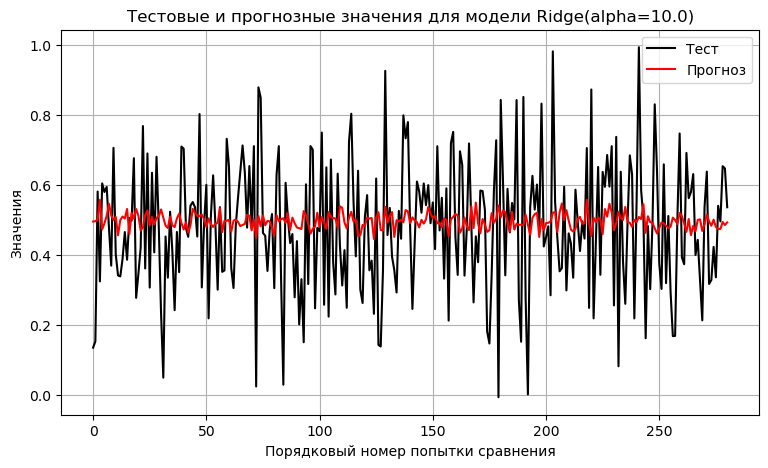

In [175]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = ridge_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, ridge_pr)

### Стохастический градиентный спуск (Stochastic Gradient Descent, SGD)

In [56]:
# Найдем лучшие параметры

sgd_pr = SGDRegressor()
sgd_params = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.5],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
    'epsilon': [0.1, 0.01, 0.001],
    'random_state': [42]  # Для воспроизводимости результатов
}
best_params_sgd_pr = find_params_pr(sgd_pr, sgd_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 15552 candidates, totalling 233280 fits

              Параметры лучшей модели SGDRegressor
alpha                                         0.01
epsilon                                        0.1
eta0                                          0.01
learning_rate                             constant
loss                   squared_epsilon_insensitive
max_iter                                      1000
penalty                                         l1
random_state                                    42
tol                                        0.00001


In [57]:
# Функция, рассчитывающая метрики MSE, MAE и R2  

evaluate_pr(sgd_pr, best_params_sgd_pr)

SGDRegressor
MSE_train        0.0369
MSE_test         0.0351
MAE_train        0.1526
MAE_test         0.1508
R2_train        -0.0204
R2_test         -0.0110

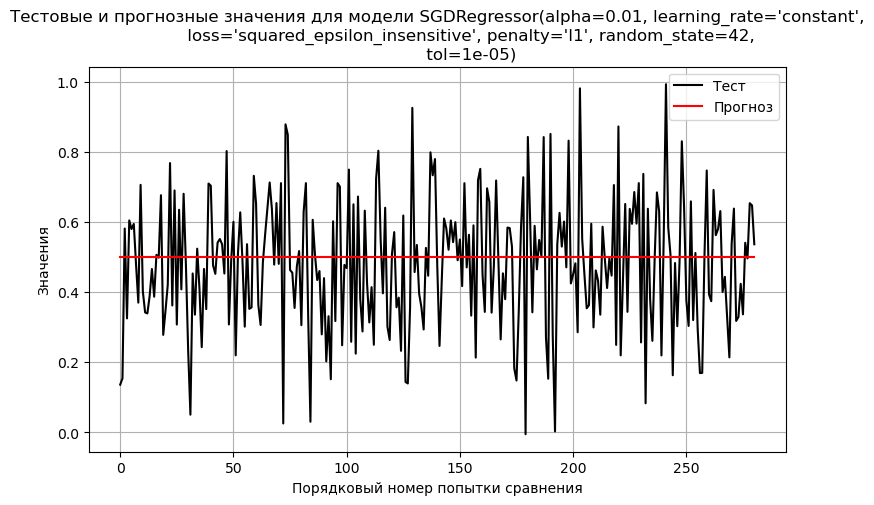

In [58]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными

y_pred = sgd_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, sgd_pr)

### Градиентный бустинг (Gradient Boosting Regressor)

In [59]:
gb_pr = GradientBoostingRegressor()
gb_params = {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 
                  'n_estimators': [1, 2, 5, 10],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 5, 10]}
best_params_gb_pr = find_params_pr(gb_pr, gb_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 320 candidates, totalling 4800 fits

             Параметры лучшей модели GradientBoostingRegressor
loss                                             squared_error
max_depth                                                    3
max_features                                                 1
n_estimators                                                10


In [60]:
# Рассчитаем метрики MSE, MAE и R2 для Lasso

evaluate_pr(gb_pr, best_params_gb_pr)

GradientBoostingRegressor
MSE_train                     0.0368
MSE_test                      0.0345
MAE_train                     0.1517
MAE_test                      0.1499
R2_train                     -0.0171
R2_test                       0.0055

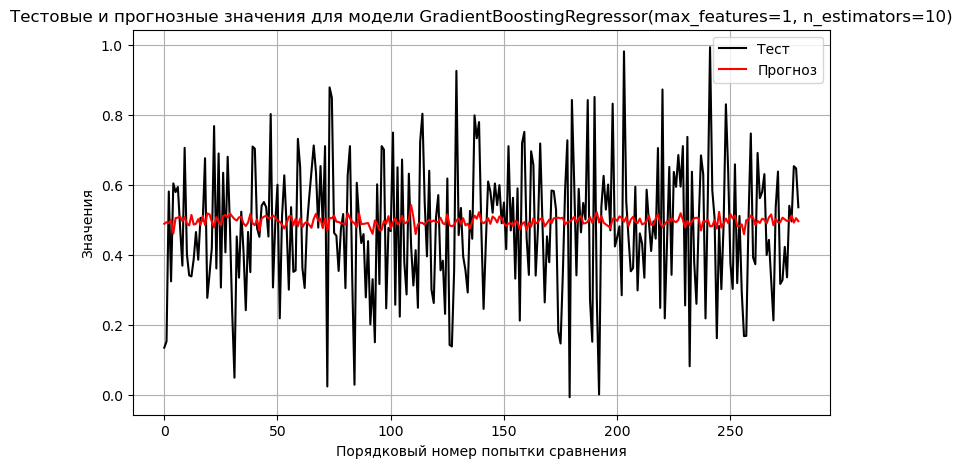

In [61]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными

y_pred = gb_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, gb_pr)

### Метод опорных векторов (Support Vector Regression, SVR)

In [62]:
# Найдем лучшие параметры

svr_pr = SVR()
svr_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'C': [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1, 0.5]}
best_params_svr_pr = find_params_pr(svr_pr, svr_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 40 candidates, totalling 600 fits

       Параметры лучшей модели SVR
C                              0.1
kernel                     sigmoid


In [63]:
# Рассчитаем метрики MSE, MAE и R2 для SVR

evaluate_pr(svr_pr, best_params_svr_pr)

SVR
MSE_train  0.0366
MSE_test   0.0349
MAE_train  0.1514
MAE_test   0.1504
R2_train  -0.0127
R2_test   -0.0057

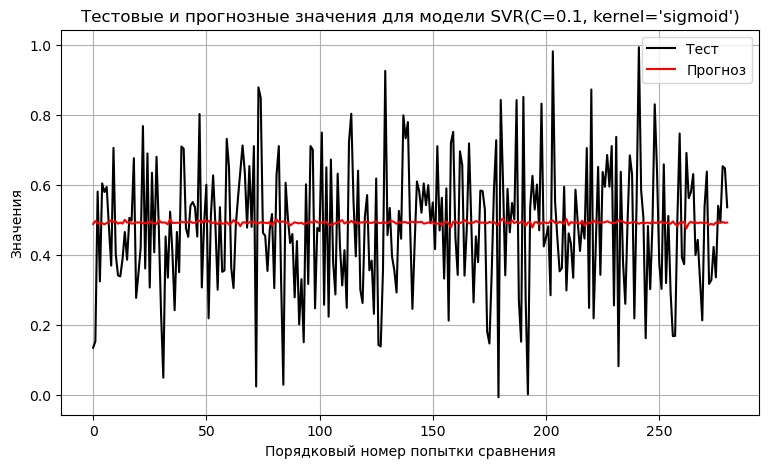

In [64]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными

y_pred = svr_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, svr_pr)

### "Случайный лес" (Random Forest Regressor)

In [65]:
# Найдем лучшие параметры

forest_pr = RandomForestRegressor(random_state=0)
forest_params = {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 5, 7],
                'min_samples_split': [2, 4, 8],
                'min_samples_leaf': [1, 2, 4],
               }
best_params_forest_pr = find_params_pr(forest_pr, forest_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits

                   Параметры лучшей модели RandomForestRegressor
max_depth                                                      2
min_samples_leaf                                               4
min_samples_split                                              2
n_estimators                                                 100


In [66]:
# Рассчитаем метрики MSE, MAE и R2 для RandomForestRegressor

evaluate_pr(forest_pr, best_params_forest_pr)

RandomForestRegressor
MSE_train                 0.0369
MSE_test                  0.0351
MAE_train                 0.1522
MAE_test                  0.1513
R2_train                 -0.0218
R2_test                  -0.0109

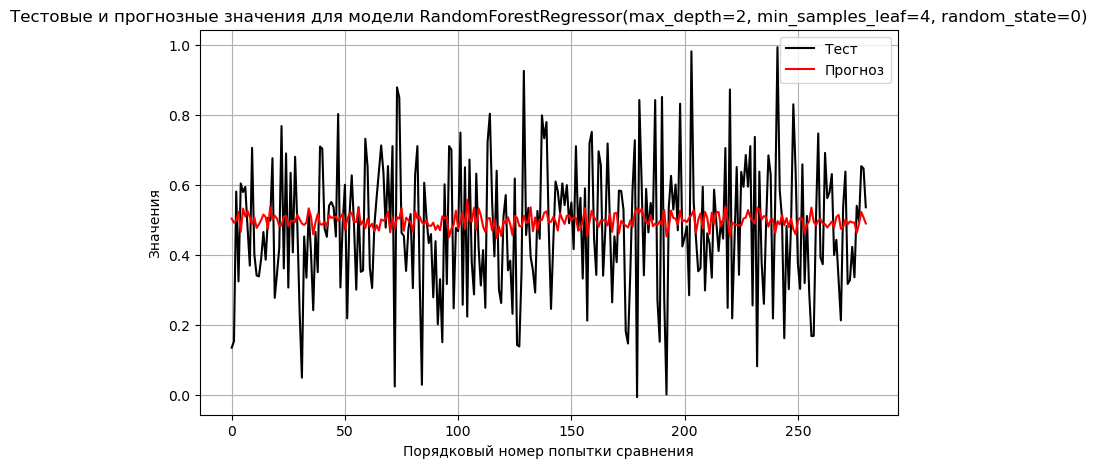

In [67]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными

y_pred = forest_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, forest_pr)

### XGBRegressor

In [68]:
xgb_pr = XGBRegressor(random_state=0)

xgb_params = {
              'booster': ['gbtree', 'dart'],            # dart - c прорежеванием
              'n_estimators': [10, 50, 100],       # число деревьев
              'max_depth': [3, 5, 7],               # максимальная глубина дерева
              'learning_rate': [0.01, 0.02, 0.1],
              'subsample': [0.5, 0.7],             # доля обучающих образцов
              'colsample_bytree': [0.5, 0.7, 1.0],      # доля обучающих признаков
              'n_jobs': [-1]
             }
best_params_xgb_pr = find_params_pr(xgb_pr, xgb_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 324 candidates, totalling 4860 fits

                 Параметры лучшей модели XGBRegressor
booster                                          dart
colsample_bytree                                  1.0
learning_rate                                    0.01
max_depth                                           7
n_estimators                                       50
n_jobs                                             -1
subsample                                         0.5


In [69]:
evaluate_pr(xgb_pr, best_params_xgb_pr)

XGBRegressor
MSE_train        0.0368
MSE_test         0.0350
MAE_train        0.1521
MAE_test         0.1514
R2_train        -0.0170
R2_test         -0.0078

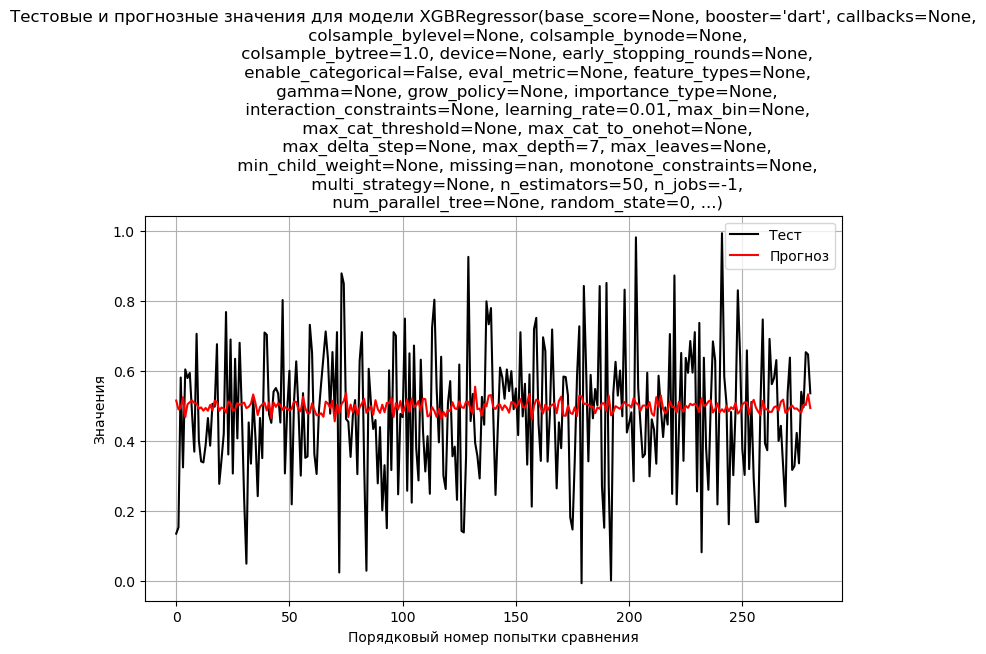

In [70]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными

y_pred = xgb_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, xgb_pr)

In [190]:
# Подберем лучшие параметры

dtr_pr = DecisionTreeRegressor()

dtr_params = {
    'max_depth': [5, 10, 20, 30],  # Глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество выборок для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество выборок в листовом узле
    'max_features': ['auto', 'sqrt', 'log2'],  # Максимальное количество признаков для разделения
}

best_params_dtr_pr = find_params_upr(dtr_pr, dtr_params, X_train_scl, y_train_scl_pr)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits

                  Параметры лучшей модели DecisionTreeRegressor
max_depth                                                     5
max_features                                               log2
min_samples_leaf                                              4
min_samples_split                                             5


In [191]:
evaluate_pr(dtr_pr, best_params_dtr_pr)

DecisionTreeRegressor
MSE_train                 0.0409
MSE_test                  0.0405
MAE_train                 0.1604
MAE_test                  0.1596
R2_train                 -0.1279
R2_test                  -0.1669

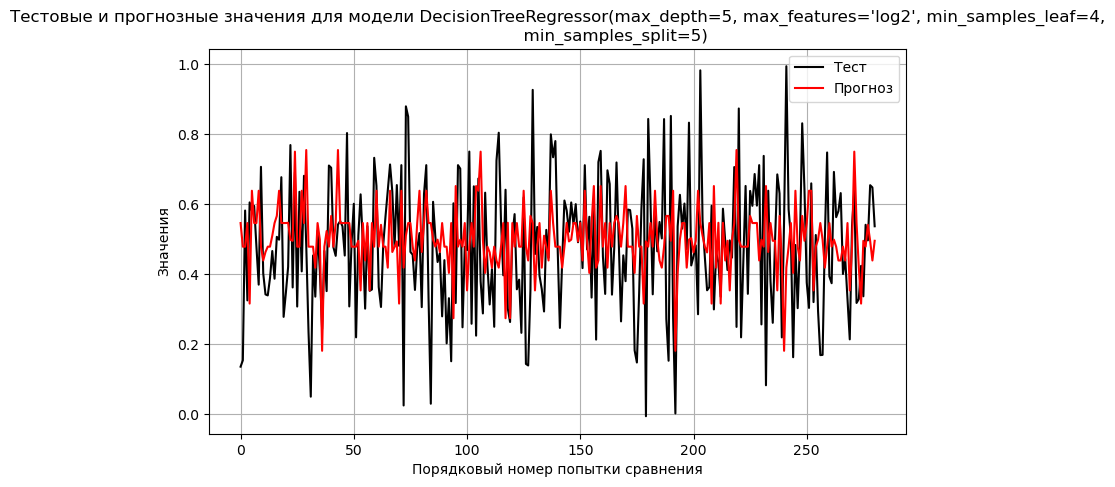

In [192]:
# Проведем прогнозирование и сравним его результаты с фактическими тестовыми данными 

y_pred = dtr_pr.predict(X_test_scl)
pred_test_visual_pr(y_test_scl_pr, y_pred, dtr_pr)

Как можно увидеть по графику, данный регрессор пытался буквально угадать значения, но, не выявив четких закономерностей, многие предсказания били мимо цели.

Теперь посмтрим на результаты обучения наших моделей.

In [193]:
total_results_pr.T

MSE_train  MSE_test  MAE_train  MAE_test  R2_train  \
LinearRegression              0.0380    0.0354     0.1550    0.1515   -0.0520   
KNeighborsRegressor           0.0369    0.0353     0.1528    0.1513   -0.0219   
SGDRegressor                  0.0369    0.0351     0.1526    0.1508   -0.0204   
GradientBoostingRegressor     0.0368    0.0345     0.1517    0.1499   -0.0171   
SVR                           0.0366    0.0349     0.1514    0.1504   -0.0127   
RandomForestRegressor         0.0369    0.0351     0.1522    0.1513   -0.0218   
XGBRegressor                  0.0368    0.0350     0.1521    0.1514   -0.0170   
Ridge                         0.0374    0.0351     0.1536    0.1509   -0.0349   
DecisionTreeRegressor         0.0409    0.0405     0.1604    0.1596   -0.1279   

                           R2_test  
LinearRegression           -0.0183  
KNeighborsRegressor        -0.0172  
SGDRegressor               -0.0110  
GradientBoostingRegressor   0.0055  
SVR                        -0.0057  
RandomForestRegressor      -0.0109  
XGBRegressor               -0.0078  
Ridge                      -0.0094  
DecisionTreeRegressor      -0.1669

Как видим, лучший результат обучения со значением R2 0.0012 на тестовой выборке показал метод Градиентного бустинга (Gradient Boosting Regressor). Результат чуть больше нуля, это значит, что модель, к сожалению, мало чем отличается по эффективности от простого усреднения.

Теперь приступим к выполнению задачи  по  построению модели нейронной сети для предсказания соотношения матрица-наполнитель.

# Нейронная сеть для предсказания соотношения матрица-наполнитель

In [136]:
# Загрузим необходимые на данном этапе библиотеки

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import models

In [137]:
# Создадим функцию по выводу метрик на тренировочных и тестовых выборках

def pred_metrics(model_name, X_train, y_train, X_test, y_test, y_pred_train, y_pred_test):
    
    # Предсказание на тренировочной выборке
    mse_train = mean_squared_error(y_train_scl_mn, y_pred_train)
    mae_train = mean_absolute_error(y_train_scl_mn,y_pred_train)
    r2_train = r2_score(y_train_scl_mn, y_pred_train)

    # Предсказание на тестовой выборке
    mse_test = mean_squared_error(y_test_scl_mn, y_pred_test)
    mae_test = mean_absolute_error(y_test_scl_mn, y_pred_test)
    r2_test = r2_score(y_test_scl_mn, y_pred_test)

    # Создание таблицы
    model_results_df = pd.DataFrame({
        model_name: {

            'MSE_train': mse_train,
            'MSE_test': mse_test,
            'MAE_train': mae_train,
            'MAE_test': mae_test,
            'R2_train': r2_train,
            'R2_test': r2_test
        }
    }, index=['MSE_train', 'MSE_test','MAE_train', 'MAE_test', 'R2_train', 'R2_test'])
     
    # Обновление глобального DataFrame
    global results_nn
    if results_nn.empty:
        results_nn = model_results_df
    else:
        results_nn = pd.concat([results_nn, model_results_df], axis=1)

    return model_results_df

In [138]:
#Функция для построения графика потерь модели на тренировочной и тестовой выборках

def model_loss_plot(model_history):
    plt.figure(figsize=(10, 5))
    plt.plot(model_history.history['loss'], label='Потери на обучении')
    plt.plot(model_history.history['val_loss'], label='Потери на валидации')
    plt.title('График потерь на обучении и валидации по эпохам', size=12)
    plt.ylabel('Потери', size=12)
    plt.xlabel('Эпохи', size=12)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [139]:
# Создадим функцию по визуализации прогнозных значений и фактических значений тестовой выборки

def orig_pred_plot(y_test_scl_mn, y_pred_test, name="Тестовые и прогнозные значения"):
    y_test_scl_mn_series = pd.Series(y_test_scl_mn.ravel())
    plt.figure(figsize=(9, 5))
    plt.title(name, size=12)
    plt.plot(y_test_scl_mn_series, color='blue', label='Тестовые значения')
    plt.plot(y_pred_test, color='red', label='Прогнозные значения')
    plt.xlabel('Строки')
    plt.ylabel('Значение у')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [140]:
# Глобальный DataFrame для хранения результатов для всех моделей

results_nn = pd.DataFrame()

Для начала возьмем и обучим нейронную есть с четырьмя слоями: одним входным, двумя скрытыми (в одном 16 нейронов, в другом 8) и одним выходным слоем с 1 нейроном. К этой модели мы не будем применять раннюю остановку, посмотрим как модель отработает без нее.

In [141]:
model_1 = Sequential()
model_1.add(Dense(X_train_scl_mn.shape[1]))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mean_squared_error')
history_1 = model_1.fit(X_train_scl_mn,
                        y_train_scl_mn,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3)

Epoch 1/100
15/15 [==============================] - 1s 9ms/step - loss: 0.1626 - val_loss: 0.0625
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0565
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0618 - val_loss: 0.0457
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0433
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0402
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0386
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0370
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0427 - val_loss: 0.0360
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0355
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0398 - val_loss: 0.0346
Epoch 11/

15/15 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0326
Epoch 84/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0335
Epoch 85/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0327
Epoch 86/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0338 - val_loss: 0.0334
Epoch 87/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0327
Epoch 88/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.0326
Epoch 89/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0330 - val_loss: 0.0335
Epoch 90/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0324
Epoch 91/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.0341
Epoch 92/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0329
Epoch 93/100


Теперь произведем прогнозирование и оценим результаты обучения.

In [142]:
# Прогнозирование и оценка результатов обучения

y_pred_train = model_1.predict(X_train_scl_mn)
y_pred_test = model_1.predict(X_test_scl_mn)
pred_metrics("Нейронная сеть_1", X_train_scl_mn, y_train_scl_mn, X_test_scl_mn, y_test_scl_mn, y_pred_train, y_pred_test)

9/9 [==============================] - 0s 871us/step


Нейронная сеть_1
MSE_train          0.032856
MSE_test           0.039658
MAE_train          0.145539
MAE_test           0.163884
R2_train           0.056390
R2_test           -0.090104

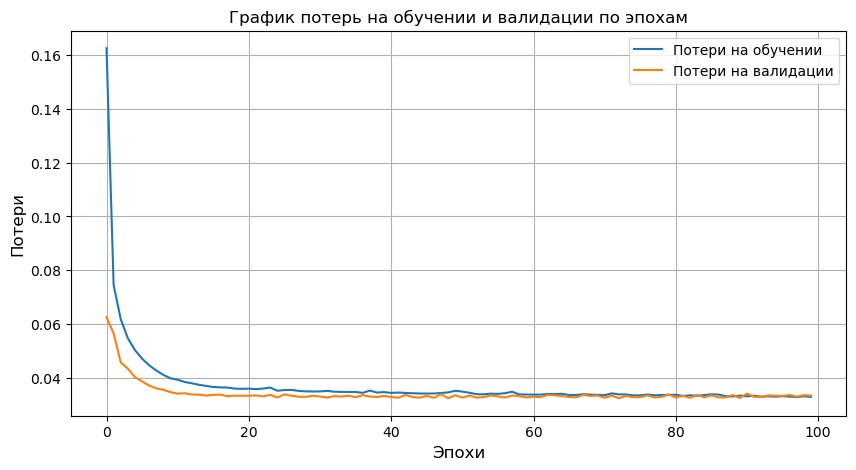

In [143]:
# Посторим график потерь на обучении и валидации

model_loss_plot(history_1)

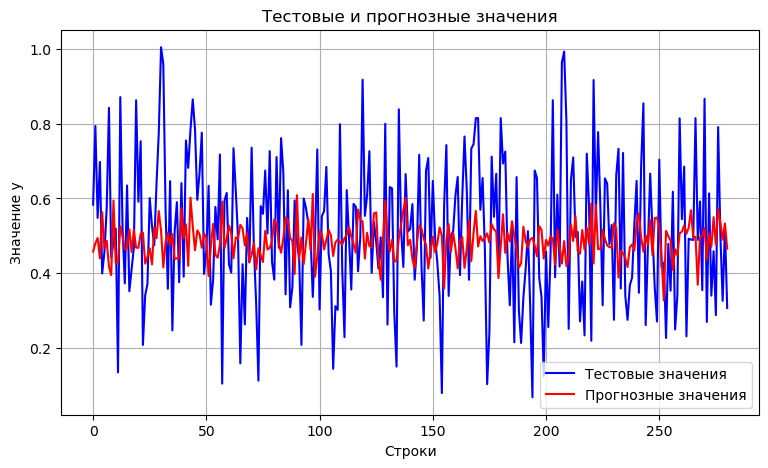

In [144]:
# Создадим визуализацию прогнозных и фактических тестовых значений.

orig_pred_plot(y_test_scl_mn, y_pred_test)

Как можно увидеть из полученных графиков и метрик, модель явно на тренировочных данных пыталась подстроится под данные. И хотя она показала, в целом, неплохие результаты на обучающей выборке, но на тестовой выборке они значительно ухудшились. Таким, образом омжно констатировать "переобучение" модели.

Теперь активируем функцию ранней остановки и посмотрим, как изменится обучение той же самой модели, и каковы будут ее результаты.

In [145]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [146]:
model_2 = Sequential()
model_2.add(Dense(X_train_scl_mn.shape[1]))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mean_squared_error')
history_2 = model_2.fit(X_train_scl_mn,
                        y_train_scl_mn,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=[early_stop])

Epoch 1/100
15/15 [==============================] - 1s 9ms/step - loss: 0.1222 - val_loss: 0.0437
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0421
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0406
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0372
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0363
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0361
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0352
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.0354
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0346
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0344
Epoch 11/

In [147]:
# Прогнозирование и оценка результатов обучения

y_pred_train = model_2.predict(X_train_scl_mn)
y_pred_test = model_2.predict(X_test_scl_mn)
pred_metrics("Нейронная сеть_2", X_train_scl_mn, y_train_scl_mn, X_test_scl_mn, y_test_scl_mn, y_pred_train, y_pred_test)

9/9 [==============================] - 0s 997us/step


Нейронная сеть_2
MSE_train          0.032987
MSE_test           0.038811
MAE_train          0.146960
MAE_test           0.160538
R2_train           0.052637
R2_test           -0.066808

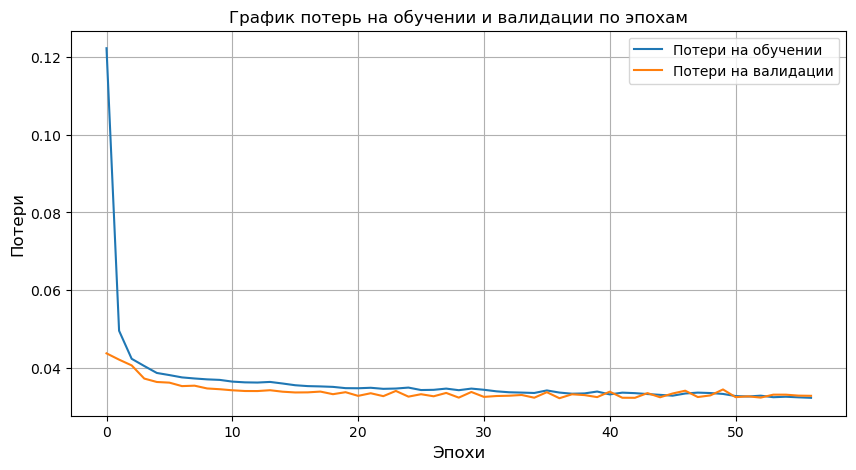

In [148]:
# Посторим график потерь на обучении и валидации

model_loss_plot(history_2)

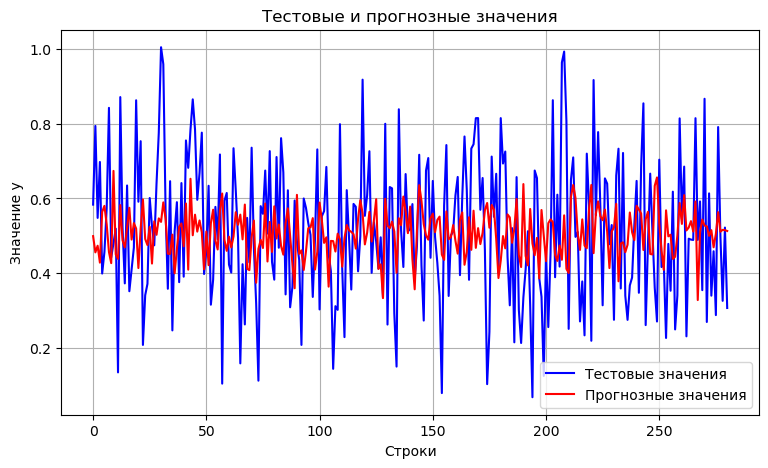

In [149]:
# Создадим визуализацию прогнозных и фактических тестовых значений.

orig_pred_plot(y_test_scl_mn, y_pred_test)

Как можно увидеть, функция ранней остановки уменьшила "переобучение" модели и результаты прогноза на тестовой выборке улучшились. В данной связи применим эту функцию для всех последующих моделей нейронных сетей.

Теперь попробуем дальше поработать с данной моделью и добавим количество нейронов в скрытые слои (32 и 16) и посмотрим, улучшится ли качество предсказаний.

In [150]:
# Попробуем увеличить количество нейронов

model_3 = Sequential()
model_3.add(Dense(X_train_scl_mn.shape[1]))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mean_squared_error')
history_3 = model_3.fit(X_train_scl_mn,
                        y_train_scl_mn,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=[early_stop])

Epoch 1/100
15/15 [==============================] - 1s 9ms/step - loss: 0.0839 - val_loss: 0.0422
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0395
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0413 - val_loss: 0.0373
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0406 - val_loss: 0.0365
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0397 - val_loss: 0.0354
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0387 - val_loss: 0.0353
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0347
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0343
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0374 - val_loss: 0.0341
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0340
Epoch 11/

In [151]:
# Прогнозирование и оценка результатов обучения

y_pred_train = model_3.predict(X_train_scl_mn)
y_pred_test = model_3.predict(X_test_scl_mn)
pred_metrics("Нейронная сеть_3", X_train_scl_mn, y_train_scl_mn, X_test_scl_mn, y_test_scl_mn, y_pred_train, y_pred_test)

9/9 [==============================] - 0s 998us/step


Нейронная сеть_3
MSE_train          0.032694
MSE_test           0.037385
MAE_train          0.144849
MAE_test           0.157800
R2_train           0.061042
R2_test           -0.027605

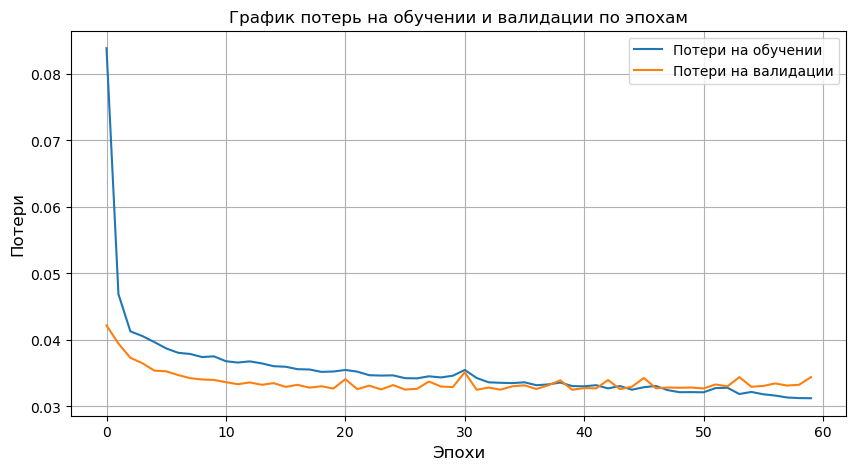

In [152]:
# Посторим график потерь на обучении и валидации

model_loss_plot(history_3)

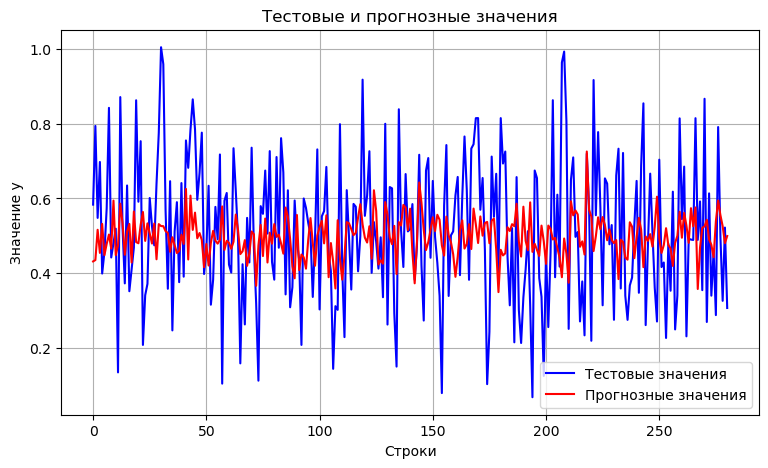

In [153]:
# Создадим визуализацию прогнозных и фактических тестовых значений.

orig_pred_plot(y_test_scl_mn, y_pred_test)

Как можно увидеть по метрикам, качество предсказаний несколько улучшилось.

Попробуем еще удвоить количество нейронов.

In [154]:
# Попробуем еще увеличить количество нейронов

model_4 = Sequential()
model_4.add(Dense(X_train_scl_mn.shape[1]))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(1, activation='linear'))

model_4.compile(optimizer='adam', loss='mean_squared_error')

history_4 = model_4.fit(X_train_scl_mn,
                        y_train_scl_mn,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=[early_stop])

Epoch 1/100
15/15 [==============================] - 1s 9ms/step - loss: 0.0922 - val_loss: 0.0422
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0454 - val_loss: 0.0364
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0338
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0376 - val_loss: 0.0333
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0367 - val_loss: 0.0327
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0328
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0323
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0321
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0334
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0319
Epoch 11/

In [155]:
# Произведем прогнозировнаие и его результаты

y_pred_train = model_4.predict(X_train_scl_mn)
y_pred_test = model_4.predict(X_test_scl_mn)
pred_metrics("Нейронная сеть_4", X_train_scl_mn, y_train_scl_mn, X_test_scl_mn, y_test_scl_mn, y_pred_train, y_pred_test)

9/9 [==============================] - 0s 865us/step


Нейронная сеть_4
MSE_train          0.032281
MSE_test           0.040680
MAE_train          0.144856
MAE_test           0.161888
R2_train           0.072903
R2_test           -0.118175

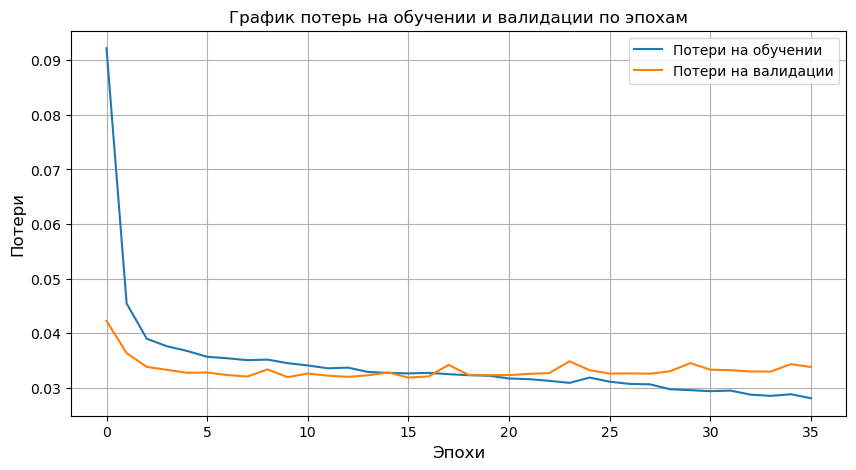

In [156]:
# Построим график потерь на обучении и валидации

model_loss_plot(history_4)

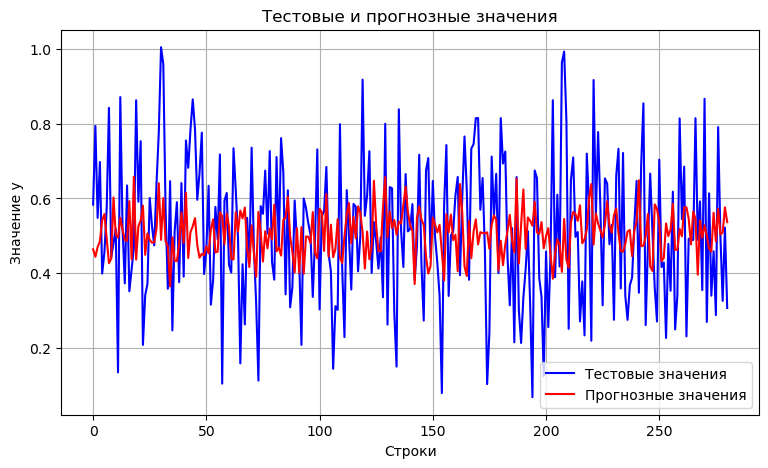

In [157]:
# Создадим визуализацию прогнозных и фактических тестовых значений.

orig_pred_plot(y_test_scl_mn, y_pred_test)

Как видим, дальнейшее увеличение количества нейронов не приводит к улучшению показателей предсказаний нейронной сети. Попробуем тогда поработать еще с другими параметрами. Третья модель была наиболее удачной, возьмем ее и поменяем метод активации скрытых слоев на 'tanh'.

In [158]:
# Поменяем метод активации скрытых слоев на 'tanh'

model_5 = Sequential()
model_5.add(Dense(X_train_scl_mn.shape[1]))
model_5.add(Dense(32, activation='tanh'))
model_5.add(Dense(16, activation='tanh'))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mean_squared_error')
history_5 = model_5.fit(X_train_scl_mn,
                        y_train_scl_mn,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=[early_stop])

Epoch 1/100
15/15 [==============================] - 1s 9ms/step - loss: 0.2102 - val_loss: 0.0868
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0664 - val_loss: 0.0518
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0404
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0414 - val_loss: 0.0379
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0403 - val_loss: 0.0345
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0354
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0332
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.0336
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.0329
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0334
Epoch 11/

In [159]:
y_pred_train = model_5.predict(X_train_scl_mn)
y_pred_test = model_5.predict(X_test_scl_mn)
pred_metrics("Нейронная сеть_5", X_train_scl_mn, y_train_scl_mn, X_test_scl_mn, y_test_scl_mn, y_pred_train, y_pred_test)

9/9 [==============================] - 0s 872us/step


Нейронная сеть_5
MSE_train          0.034110
MSE_test           0.037595
MAE_train          0.148250
MAE_test           0.158662
R2_train           0.020387
R2_test           -0.033389

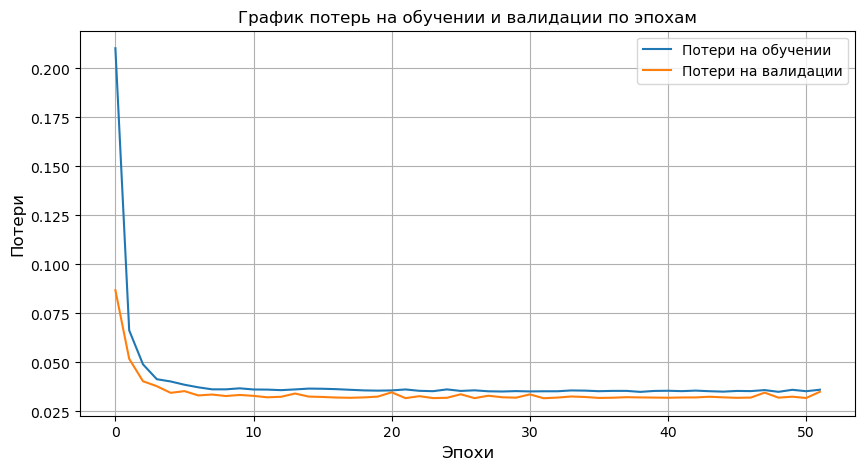

In [160]:
model_loss_plot(history_5)

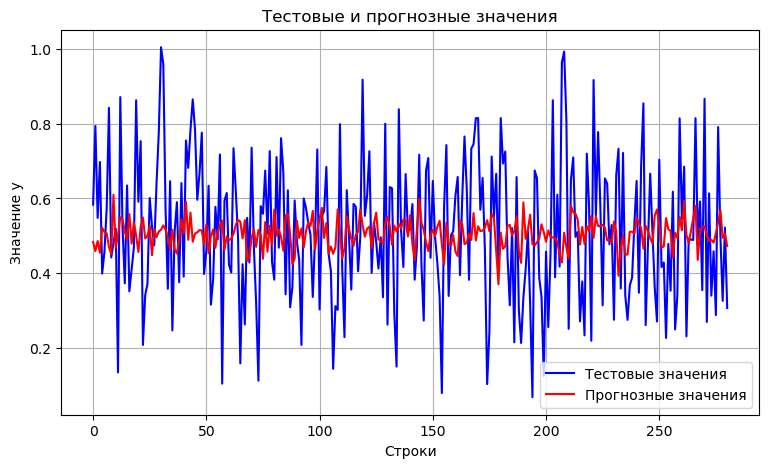

In [161]:
# Создадим визуализацию прогнозных и фактических тестовых значений.

orig_pred_plot(y_test_scl_mn, y_pred_test)

Попробуем поменять оптимайзер на 'sgd' и посмотрим, изменится ли что-то.

In [162]:
# Попробуем поменять оптимайзер на 'sgd'

model_6 = Sequential()
model_6.add(Dense(X_train_scl_mn.shape[1]))
model_6.add(Dense(64, activation='tanh'))
model_6.add(Dense(32, activation='tanh'))
model_6.add(Dense(1))
model_6.compile(optimizer='sgd', loss='mean_squared_error')
history_6 = model_6.fit(X_train_scl_mn,
                        y_train_scl_mn,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=[early_stop])

Epoch 1/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0720 - val_loss: 0.0453
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0433
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0454 - val_loss: 0.0417
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0405
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0391
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0380
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0408 - val_loss: 0.0368
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0397 - val_loss: 0.0394
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.0356
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0393 - val_loss: 0.0354
Epoch 11/

In [163]:
y_pred_train = model_6.predict(X_train_scl_mn)
y_pred_test = model_6.predict(X_test_scl_mn)
pred_metrics("Нейронная сеть_6", X_train_scl_mn, y_train_scl_mn, X_test_scl_mn, y_test_scl_mn, y_pred_train, y_pred_test)

9/9 [==============================] - 0s 997us/step


Нейронная сеть_6
MSE_train          0.034297
MSE_test           0.037866
MAE_train          0.149332
MAE_test           0.159458
R2_train           0.015004
R2_test           -0.040827

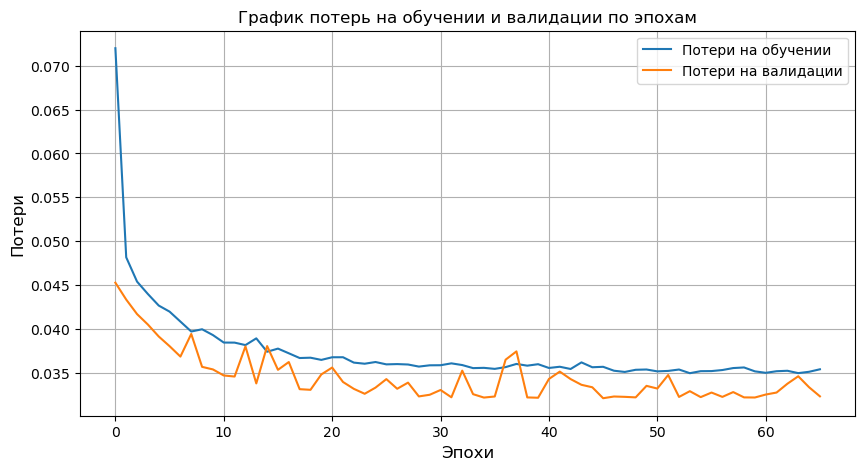

In [164]:
# Построим график потерь на обучении и валидации

model_loss_plot(history_6)

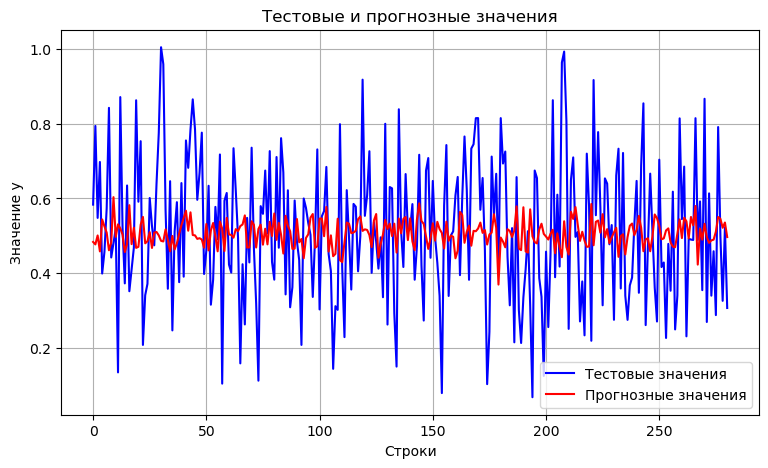

In [165]:
# Создадим визуализацию прогнозных и фактических тестовых значений.

orig_pred_plot(y_test_scl_mn, y_pred_test)

# Итоговые результаты обучения моделей

In [186]:
results_nn.T

MSE_train  MSE_test  MAE_train  MAE_test  R2_train   R2_test
Нейронная сеть_1   0.032856  0.039658   0.145539  0.163884  0.056390 -0.090104
Нейронная сеть_2   0.032987  0.038811   0.146960  0.160538  0.052637 -0.066808
Нейронная сеть_3   0.032694  0.037385   0.144849  0.157800  0.061042 -0.027605
Нейронная сеть_4   0.032281  0.040680   0.144856  0.161888  0.072903 -0.118175
Нейронная сеть_5   0.034110  0.037595   0.148250  0.158662  0.020387 -0.033389
Нейронная сеть_6   0.034297  0.037866   0.149332  0.159458  0.015004 -0.040827

In [187]:
total_results_upr.T

MSE_train  MSE_test  MAE_train  MAE_test  R2_train  \
LinearRegression              0.0369    0.0379     0.1532    0.1605   -0.0185   
KNeighborsRegressor           0.0364    0.0380     0.1518    0.1620   -0.0060   
SGDRegressor                  0.0421    0.0386     0.1632    0.1625   -0.1696   
GradientBoostingRegressor     0.0364    0.0376     0.1524    0.1600   -0.0025   
SVR                           0.0365    0.0371     0.1525    0.1589   -0.0059   
RandomForestRegressor         0.0362    0.0380     0.1516    0.1606    0.0013   
XGBRegressor                  0.0379    0.0400     0.1543    0.1641   -0.0435   
Ridge                         0.0366    0.0375     0.1526    0.1598   -0.0092   
DecisionTreeRegressor         0.0410    0.0406     0.1598    0.1659   -0.1330   

                           R2_test  
LinearRegression           -0.0193  
KNeighborsRegressor        -0.0233  
SGDRegressor               -0.0378  
GradientBoostingRegressor  -0.0123  
SVR                         0.0025  
RandomForestRegressor      -0.0221  
XGBRegressor               -0.0773  
Ridge                      -0.0088  
DecisionTreeRegressor      -0.0918

In [194]:
total_results_pr.T

MSE_train  MSE_test  MAE_train  MAE_test  R2_train  \
LinearRegression              0.0380    0.0354     0.1550    0.1515   -0.0520   
KNeighborsRegressor           0.0369    0.0353     0.1528    0.1513   -0.0219   
SGDRegressor                  0.0369    0.0351     0.1526    0.1508   -0.0204   
GradientBoostingRegressor     0.0368    0.0345     0.1517    0.1499   -0.0171   
SVR                           0.0366    0.0349     0.1514    0.1504   -0.0127   
RandomForestRegressor         0.0369    0.0351     0.1522    0.1513   -0.0218   
XGBRegressor                  0.0368    0.0350     0.1521    0.1514   -0.0170   
Ridge                         0.0374    0.0351     0.1536    0.1509   -0.0349   
DecisionTreeRegressor         0.0409    0.0405     0.1604    0.1596   -0.1279   

                           R2_test  
LinearRegression           -0.0183  
KNeighborsRegressor        -0.0172  
SGDRegressor               -0.0110  
GradientBoostingRegressor   0.0055  
SVR                        -0.0057  
RandomForestRegressor      -0.0109  
XGBRegressor               -0.0078  
Ridge                      -0.0094  
DecisionTreeRegressor      -0.1669

Как можно увидеть, лучшие результаты прогнозирования были получены посредством использования алгоритмов машинного обучения "Метод опорных векторов" (SVR) для прогнозирования параметра "Модуль упругости при растяжении" и градиентный бустинг (GradientBoostingRegressor) для прогнозирования параметра "Прочность при растяжении", для параметра "Матрица-наполнитель" лучшей моделью нейронной сети стал вариант под номером 3.

Сохраним их полученные лучшие модели, которые будут использованы на следующем этапе при создании приложения по предсказанию всех трех параметров композиционных материалов.

In [158]:
with open('flask/models/svr_upr.pickle', 'wb') as f:
    pickle.dump(svr_upr, f)

In [159]:
with open('flask/models/gb_pr.pickle', 'wb') as f:
    pickle.dump(gb_pr, f)

In [160]:
model_3.save('flask/models/best_model_mn.h5', save_format='h5')